# Machine Learning for Time Domain Astronomy
ZTF Summer School 2023

----

Requirements:
- Matrix Convolution/Kernel operations: https://en.wikipedia.org/wiki/Kernel_(image_processing)
- Neural Networks/Perceptron: http://neuralnetworksanddeeplearning.com/chap1.html#perceptrons
- Convolutional Neural Networks (CNN): http://neuralnetworksanddeeplearning.com/chap6.html#introducing_convolutional_networks
- Tensorflow and Keras, which we'll use to create the models and train them: https://www.tensorflow.org/tutorials/keras/classification
- ZTF alerts: https://www.ztf.caltech.edu/ztf-alert-stream.html and https://iopscience.iop.org/article/10.1088/1538-3873/aae904/pdf

Optional, but recommended:
- Weights and Biases Quickstart: https://docs.wandb.ai/quickstart (you will need to create an account anyway!)
- Early stopping: https://en.wikipedia.org/wiki/Early_stopping
- Dropout: https://en.wikipedia.org/wiki/Dilution_(neural_networks)
- Plateau phenomenon: https://analyticsindiamag.com/what-is-the-plateau-problem-in-neural-networks-and-how-to-fix-it


----

Overview:

We'll have a look at how the alert scanning process can be automatized (or at least facilitated) by teaching neural networks how to look at the cutouts and metadata from the alert packets just like humans would. We'll talk about the model's architecture, how to train it, evaluate it, and how to fine-tune it with the help of wandb.ai.


In [1]:
# but of course, let's start with the imports
import numpy as np
import pandas as pd
import tensorflow as tf
import wandb
from ast import literal_eval

from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate, SeparableConv2D, GlobalAveragePooling2D, BatchNormalization, Activation
import scipy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Downloading the dataset (run only once):

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16ufsYYbpJ0ZWw2ZIibPfQQ81k7OBNl9Z' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16ufsYYbpJ0ZWw2ZIibPfQQ81k7OBNl9Z" -O data.zip && rm -rf /tmp/cookies.txt
!unzip data.zip -d data

----

## Introduction

### Quick reminder: Convolutional Neural Network (CNN)

"In deep learning, a convolutional neural network (CNN) is a class of artificial neural network most commonly applied to analyze visual imagery.[1] CNNs use a mathematical operation called convolution in place of general matrix multiplication in at least one of their layers.[2] They are specifically designed to process pixel data and are used in image recognition and processing."
*https://en.wikipedia.org/wiki/Convolutional_neural_network*

<img src="https://miro.medium.com/v2/resize:fit:1162/format:webp/1*tvwYybdIwvoOs0DuUEJJTg.png" alt="Drawing" style="width: 800px;"/>
<p style="font-size: 10px;">Source: https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697</p>


A basic CNN is composed of several layers:
- Convolutional layers: they apply a convolution operation to the input, passing the result to the next layer.
- Pooling layers: they downsample the input along the spatial dimensions (width, height), reducing the number of parameters and computation in the network.
- Fully connected layers: they compute the class scores, resulting in a vector of size equal to the number of classes. If the classification we expect is binary (simply True if >0.5, otherwise False), the last layer is a single neuron with a sigmoid activation function.

The input can be either a single image, composed of one or more channels (e.g. RGB), or a batch of images of the same size. When it comes to the cutouts found in the ZTF alert packets, they are a set of 3 images (science, template, difference) of size 63x63 pixels, each with 1 channel (grayscale). Meaning the imput is of size (63, 63, 3).

<img src="./alert_cutouts.png" alt="Drawing" style="width: 800px;"/>
<p style="font-size: 10px;">Screenshot (from fritz.science) of the cutouts from the latest alert for ZTF23aaqqfac</p>

### What about metadata?

Often, the data available isn't just one or more image, but also metadata that was computed which can be used to improve the classification. For example, the metadata can be the position of the object, the time of the observation, the magnitude of the object, etc. The metadata can be used in two ways:
- As an additional input to the CNN, concatenated to the image.
- As an additional input to the CNN, concatenated to the output of the last convolutional layer.

Later in this notebook, you'll see that the process of "merging" the CNN model and the metadata (which is a classic neural network) model into one is extremely simple.

The metadata goes through its own set of fully connected layers, and the output is concatenated to the output of the last convolutional layer after it has been flattened. The resulting vector is then fed to the fully connected layers that later compute the class scores. The BTS model aims to predict one thing: the probability that the object is a bright transient, of interest for the Bright Transient Survey (BTS) group.

<img src="http://neuralnetworksanddeeplearning.com/images/tikz11.png" alt="Drawing" style="width: 800px; background-color: white;"/>
<p style="font-size: 10px;">Basic neural network with 2 hidden layers, with one neuron as an ouput to perform binary classification. Just like the one our alert metadata will go through. Source: http://neuralnetworksanddeeplearning.com/chap1.html</p>

### But why do we need AI for any of this?

<img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa327668d-b172-44e7-a2b0-4671c235ce79_682x500.jpeg" alt="Drawing" style="width: 600px;"/>

"The Bright Transient Survey (BTS) relies on visual inspection (“scanning”) to select sources
for accomplishing its mission of spectroscopically classifying all bright extragalactic transients
found by the Zwicky Transient Facility (ZTF).
We present BTSbot, a multi-input convolutional
neural network, which provides a bright transient
score to individual ZTF detections using their image data and 14 extracted features. BTSbot eliminates the need for scanning by automatically identifying and requesting follow-up observations of
new bright (m < 18.5 mag) transient candidates.
In validation, BTSbot outperforms BTS scanners in terms of completeness (99% vs. 95%) and
identification speed (on average, 7.4 h quicker)."

Source: Nabeel :)

To summarize: Instead of relaying on people to look at thousands of alerts every day to find which one are worth getting a spectra for, we train a model to do it for us. Just like a person scanning, the model can look at both images and metadata, except more consistently and orders of magnitude faster.

----

## BTS model

As mentioned earlier, the model is composed of two parts: the CNN and the metadata part, merged to yield one output. Here is what it looks like:

### Architecture:

CNN model:
- 2 blocks of 2 convolutional layers, each followed by a pooling layer, and a dropout layer.
- a flatten layer.

Metadata model:
- 2 fully connected layers.

Merged model:
- the output of the flatten layer of the CNN model is concatenated to the output of the metadata model.
- Followed by one fully connected layer, a dropout layer, and the output layer (a single neuron with a sigmoid activation function).


In [2]:
# we define some basic constants.
config = {
    'image_size': (63,63,3),
    'metadata_size': (14,),
    'dropout_1': 0.3,
    'dropout_2': 0.3,
    'dropout_3': 0.3,
}

In [3]:
# first we prepare the input layers
triplet_input = keras.Input(shape=config["image_size"], name='triplet')
meta_input = keras.Input(shape=config["metadata_size"], name='metadata')

CNN part of the model:

#### FIRST EXERCISE: Re-design the model based on these specifications:
1. Conv branch:
    1. First convolutional block is made of 2 consecutive convolutional layers with 16 filters each, followed by a pooling layer, and a dropout layer
    2. Second convolutional block is made of 2 consecutive convolutional layers with 32 filters each, followed by a pooling layer, and a dropout layer
    3. The flatten layer is the output of the second convolutional block
2. Metadata branch:
    1. First fully connected layer with 32 neurons
    2. Second fully connected layer with 16 neurons
3. Merged model:
    1. The output of the flatten layer of the CNN model is concatenated to the output of the metadata model
    2. Followed by one fully connected layer with 32 neurons, a dropout layer, and the output layer (a single neuron with a sigmoid activation function)

In [4]:
# then we define the model, and make sure that the very last layer (the output) is called as such
# Conv branch
x = Conv2D(16, (3,3), activation='relu', padding="same")(triplet_input)
x = Conv2D(16, (3,3), activation='relu', padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(config["dropout_1"])(x)

x = Conv2D(32, (3,3), activation='relu', padding="same")(x)
x = Conv2D(32, (3,3), activation='relu', padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(config["dropout_2"])(x)

x = Flatten()(x)

# Metadata branch
y = Dense(32, activation='relu')(meta_input)
y = Dense(16, activation='relu')(y)

# Concatenate the two branches
combined = Concatenate()([x, y])
x = Dense(32, activation='relu')(combined)
x = Dropout(config["dropout_3"])(x)
output = Dense(1, activation='sigmoid', name='output')(x)

We compile the model:

In [5]:
model = keras.Model(inputs=[triplet_input, meta_input], outputs=output)

Let's have a look at the model with a graph:

<img src="./model.png" alt="Drawing" style="width: 500px;"/>

Easy, right? :)

Let's just test it on a fake input, to verify that the model is working as expected (all the layers are connected correctly, the inputs and outputs has the right shape, etc.)

In [6]:
# test the model on a random input
data_test_triplet = np.random.random((1,63,63,3))
data_test_meta = np.random.random((1,14))
print(model.predict([data_test_triplet, data_test_meta]))

1/1 [==============================] - 2s 2s/step
[[0.5453166]]


Let's just refactor all this to have a nice method to instantiate a model:

In [7]:
def BTSModel(config):
    # based on the config passed, generate the model
    # first we prepare the input layers
    triplet_input = keras.Input(shape=config['image_size'], name='triplet')
    meta_input = keras.Input(shape=config['metadata_size'], name='metadata')

    # Conv branch
    x = Conv2D(16, (3,3), activation='relu', padding="same")(triplet_input)
    x = Conv2D(16, (3,3), activation='relu', padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(config["dropout_1"])(x)

    x = Conv2D(32, (3,3), activation='relu', padding="same")(x)
    x = Conv2D(32, (3,3), activation='relu', padding="same")(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Dropout(config["dropout_2"])(x)

    x = Flatten()(x)

    # Metadata branch
    y = Dense(32, activation='relu')(meta_input)
    y = Dense(16, activation='relu')(y)

    # Concatenate the two branches
    combined = Concatenate()([x, y])
    x = Dense(32, activation='relu')(combined)
    x = Dropout(config["dropout_3"])(x)
    output = Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[triplet_input, meta_input], outputs=output)

    return model

In [8]:
model = BTSModel(config)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 triplet (InputLayer)        [(None, 63, 63, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 63, 63, 16)           448       ['triplet[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 63, 63, 16)           2320      ['conv2d_4[0][0]']            
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 16)           0         ['conv2d_5[0][0]']            
 g2D)                                                                                       

Great, we have a model that works. But just like a baby's brain (but even worse), this thing can't do anything! It needs to be trained through trial and error, just like the scanners would. Let's spoon feed it with a ton of data so it can steal our jobs faster :)

<img src="https://styles.redditmedia.com/t5_adbcw/styles/communityIcon_anc30b6ykk461.jpg" alt="Drawing" style="width: 400px;"/>
<p style="font-size: 10px;">Source: https://www.reddit.com/r/machinelearningmemes</p>

### Training the model

We'll start by creating a training loop, which will be used to train the model.

In [9]:
# we add to our config some of the constants used in the training process
config.update({
    'batch_size': 32,
    'epochs': 10,
    'learning_rate': 0.001,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'random_seed': 42,
    'train_data_version': "ZTFSS",
    'early_stopping_patience': 10,
    'LR_plateau_patience': 20,
    'reduce_LR_factor': 0.5,
    'reduce_LR_minLR': 1e-6, 
    'beta_1': 0.9,
    'beta_2': 0.999,
    'metadata_cols': [
      "sgscore1",
      "distpsnr1",
      "sgscore2",
      "distpsnr2",
      "fwhm",
      "magpsf",
      "sigmapsf",
      "ra",
      "dec",
      "diffmaglim",
      "ndethist",
      "nmtchps",
      "age",
      "peakmag_so_far"
    ],
})

In [10]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(config["random_seed"])

##### => TEMPORARY SECTION, TO REPLACE ONCE WE HAVE THE DATASET

##### Loading the data:
For this session, the dataset is already prepared and stored for you to use. It is composed of N alerts, each with 3 cutouts (science, template, difference) and 14 metadata features (2 of these features have been computed by us based on the alert history for a given object, and do not come with the basic alert packet). The training set is used to train the model, the validation set is used to evaluate the model during training.

Later (after the training), we'll use the test set to evaluate the model on data it has never seen before. This is important to make sure the model is not overfitting the training data, and that it can generalize to new data.

In [11]:
# read the data from the csv and npy files you downloaded earlier
cand = pd.read_csv(f'data/train_cand_{config["train_data_version"]}.csv')
triplets = np.load(f'data/train_triplets_{config["train_data_version"]}.npy', mmap_mode='r')
val_cand = pd.read_csv(f'data/val_cand_{config["train_data_version"]}.csv')
val_triplets = np.load(f'data/val_triplets_{config["train_data_version"]}.npy', mmap_mode='r')

gen_cols = np.append(config['metadata_cols'], ['label'])

x_train, y_train = triplets, cand['label']
x_validation, y_validation = val_triplets, val_cand['label']

# train_df is a combination of the desired metadata cols and y_train (labels)
# we provide the model a custom generator function to separate these as necessary
train_df = cand[gen_cols]
validation_df = val_cand[gen_cols]

In [12]:
split_size = int(len(x_validation) * 0.1)

# Validation data
x_val, y_val = x_validation[split_size:], y_validation[split_size:]
val_df = validation_df[split_size:]

# Test data
x_test, y_test = x_validation[:split_size], y_validation[:split_size]
test_df = validation_df[:split_size]

In [13]:
print("Training Set:", x_train.shape, y_train.shape, train_df.shape)
print("Validation Set:", x_val.shape, y_val.shape, val_df.shape)
print("Test Set:", x_test.shape, y_test.shape, test_df.shape)

Training Set: (10359, 63, 63, 3) (10359,) (10359, 15)
Validation Set: (26351, 63, 63, 3) (26351,) (26351, 15)
Test Set: (2927, 63, 63, 3) (2927,) (2927, 15)


Next, we prepare the data a little further for the training loop. We'll use the tf.keras.preprocessing.image.ImageDataGenerator to perform some data augmentation, which will help the model generalize better.

Also, we will weight the classes to account for the class imbalance. The weight of each class is the inverse of the class frequency in the training set, in case we have more BTS than non-BTS objects, or the opposite. This will help the model learn to classify both classes equally well, and reduce the false positives and false negatives rates.

In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

t_generator = train_datagen.flow(x_train, train_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)
v_generator = val_datagen.flow(x_val, val_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)

def multiinput_train_generator():
    while True:
        # get the data from the generator
        # data is [[img], [metadata and labels]]
        # yields batch_size number of entries
        data = t_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

def multiinput_val_generator():
    while True:
        data = v_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

training_generator = multiinput_train_generator()
validation_generator = multiinput_val_generator()

# weight data on number of ALERTS per class
num_training_examples_per_class = np.array([np.sum(cand['label'] == 0), np.sum(cand['label'] == 1)])

# fewer examples -> larger weight
weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
normalized_weight = weights / np.max(weights)

class_weight = {i: w for i, w in enumerate(normalized_weight)}
print(f"Class weights: {class_weight}")

Class weights: {0: 0.5017396346767178, 1: 1.0}


Instead of training our model for a fixed number of epochs, we'll use early stopping. This means that the model will train until it stops improving, and then stop. This is done by monitoring the validation loss, and stopping the training if it doesn't improve for a set number of epochs (patience).
Also, to keep training further once we plateau, we'll use a learning rate scheduler. This will reduce the learning rate by a factor of N (dividing it) once the validation loss stops improving for a set number of epochs (patience).

You might have seen in the config earlier that we still specify a number of epochs. You can see this as a maximum number of epochs, which will be reached if the model doesn't stop training before with early stopping.

In [15]:
# we set some rules to stop the training process early if the validation loss does not improve
# halt training if no improvement in validation loss over patience epochs

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=config["early_stopping_patience"],
)

# reduce learning rate if no improvement in validation loss over patience epochs

LR_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    patience=config["LR_plateau_patience"],
    factor=config["reduce_LR_factor"],
    min_lr=config["reduce_LR_minLR"]
)

We'll use [Weights and Biases](https://wandb.ai/) to log the training metrics, and to save the model. You can create a free account on https://wandb.ai/ to log your own metrics. Later in this notebook, we'll make even better use of wandb.ai to fine-tune the model with the *sweeps* feature.

In [16]:
wandb.init(project="BTSbot")
# Send parameters of this run to WandB
for param in list(config):
    wandb.config[param] = config[param]

run_name = wandb.run.name
WandBLogger = wandb.keras.WandbMetricsLogger(log_freq=5)

wandb: Currently logged in as: theobonzi. Use `wandb login --relogin` to force relogin


We'll use an Adam optimizer, which is a popular optimizer for deep learning. It is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks. It's a little more complex than the classic Stochoastic Gradient Descent (SGD) optimizer, but it's more efficient and requires less manual tuning.

In [17]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=config['learning_rate'], beta_1=config['beta_1'], beta_2=config['beta_2'])

model.compile(optimizer=optimizer, loss=config['loss'], metrics=['accuracy'])

#PS: If you are using tensorflow v2.11+ on M1/M2/M3 macs, you might benefit from using
# the legacy version of the optimizer, which is: tf.keras.optimizers.legacy.Adam

**Now (finally!), let's train the model!**

In [18]:
h = model.fit(
    training_generator,
    steps_per_epoch=0.8*len(x_train) // config["batch_size"],
    validation_data=validation_generator,
    validation_steps=(0.8*len(x_val)) // config["batch_size"],
    epochs=30,
    class_weight=class_weight,
    verbose=1, callbacks=[early_stopping, LR_plateau, WandBLogger]
)

Epoch 1/30


2023-12-17 13:40:41.111750: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


258/258 [==============================] - 9s 20ms/step - loss: 0.4784 - accuracy: 0.6461 - val_loss: 0.6100 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 2/30
258/258 [==============================] - 8s 29ms/step - loss: 0.3942 - accuracy: 0.7205 - val_loss: 0.6578 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 3/30
258/258 [==============================] - 5s 19ms/step - loss: 0.3886 - accuracy: 0.7271 - val_loss: 0.6296 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 4/30
258/258 [==============================] - 5s 19ms/step - loss: 0.3881 - accuracy: 0.7272 - val_loss: 0.6342 - val_accuracy: 0.6686 - lr: 0.0010
Epoch 5/30
258/258 [==============================] - 4s 17ms/step - loss: 0.3867 - accuracy: 0.7317 - val_loss: 0.6448 - val_accuracy: 0.6688 - lr: 0.0010
Epoch 6/30
258/258 [==============================] - 4s 17ms/step - loss: 0.3853 - accuracy: 0.7336 - val_loss: 0.6151 - val_accuracy: 0.6782 - lr: 0.0010
Epoch 7/30
258/258 [==============================] - 4s 17ms/step - loss: 

In [19]:
import matplotlib.pyplot as plt

def plot_history(history):
    history_dict = history.history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Training Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

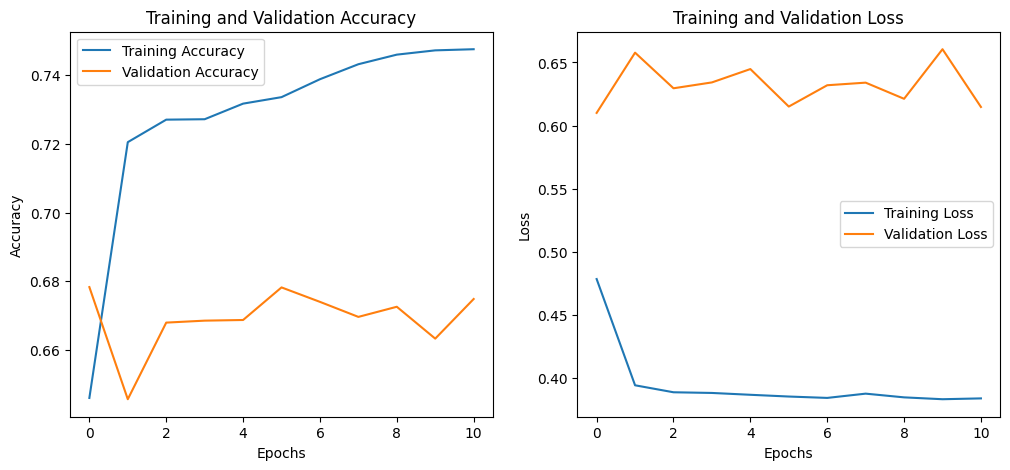

In [20]:
plot_history(h)

<a id="Testing-the-model"></a>
### Testing the model

Now, we'll load some test data to evaluate the model on data it has never seen before. This is important to make sure the model is not overfitting the training data, and that it can generalize to new data. Also, it will set a baseline for us to compare the model we'll fine-tune later.

In [21]:
# Test the model on the validation data
imgs_test = x_test
cols_test = test_df.drop("label", axis=1)
targets_test = test_df["label"]

pred = model.predict([x_test, cols_test], batch_size=config['batch_size'], verbose=1)

round_pred = np.round(pred).astype(int)

results = round_pred == targets_test.values.reshape(-1,1)

print(f"Test accuracy: {100*np.sum(results) / len(results):.2f}%")

92/92 [==============================] - 0s 2ms/step
Test accuracy: 67.54%


As you can see, the accuracy isn't too bad, and it looks like the model already learned from the data with the hyperparameters we chose. But we can do better!

**However**, accuracy isn't the only metric we should look at. There're a lot more metrics that can be used to evaluate a model, and it's important to look at them all to get a better idea of how the model is performing. For example, the accuracy can be misleading if the dataset is imbalanced (which is the case here). If we have 99% of non-BTS objects, and 1% of BTS objects, a model that always predicts non-BTS will have an accuracy of 99%, but it's not a good model. This is why we'll look can look at the confusion matrix, the precision, the recall, and the F1 score.

**Here is are your first set of tasks:**

1. Using matplotlib or your favorite plotting library, plot the confusion matrix for the test set. Hint: You can use the [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function to compute the confusion matrix, and the [sklearn.metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) to plot it.
2. Calculate the precision, recall, and F1 score for the test set. Hint: sklearn has some tools to help you with that :)
3. Nowadays, it's more common to also look at a Receiver Operating Characteristic (ROC) curve and AUC: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc. Plot the ROC curve and compute the AUC for the test set.

For each of the plots and metrics you come up with, try your best to interpret the results. What do they mean? What do they tell you about the model? What can you conclude from them?

----


In [22]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

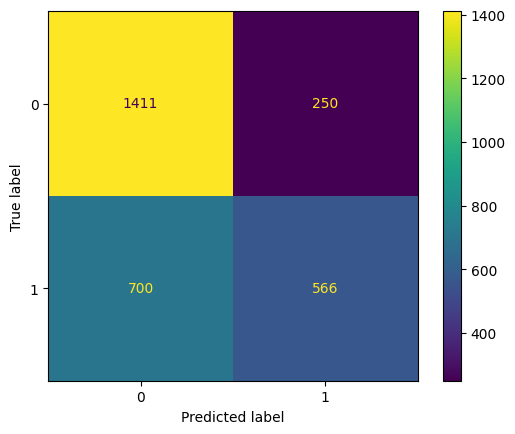

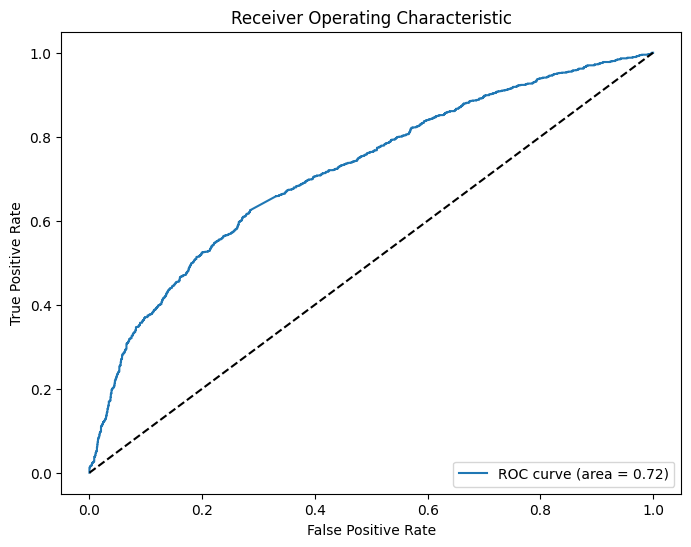

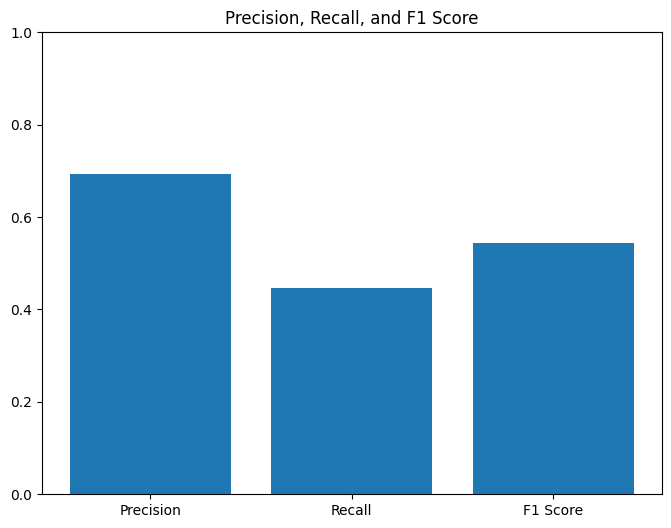

Precision: 0.6936274509803921
Recall: 0.4470774091627172
F1 Score: 0.5437079731027858
AUC: 0.7167849360812546


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

def plot_metric(targets_test, round_pred, pred):
    # Compute the confusion matrix
    cm = confusion_matrix(targets_test, round_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    # Calculate precision, recall, and F1 score
    precision = precision_score(targets_test, round_pred)
    recall = recall_score(targets_test, round_pred)
    f1 = f1_score(targets_test, round_pred)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(targets_test, pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot precision, recall, and F1 score
    plt.figure(figsize=(8, 6))
    x = ['Precision', 'Recall', 'F1 Score']
    y = [precision, recall, f1]
    plt.bar(x, y)
    plt.ylim([0.0, 1.0])
    plt.title('Precision, Recall, and F1 Score')
    plt.show()

    # Print the metrics
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", roc_auc)

plot_metric(targets_test, round_pred, pred)

## Confusion Matrix:
The confusion matrix with 1411 true positives and 566 true negatives indicates the model is effective at correctly classifying both positive and negative cases, but there are still notable errors with 700 false positives and 250 false negatives.

## Precision (0.6936):
A precision of 69.36% suggests that when the model predicts a positive result, it is accurate about 69,36%.

## Recall (0.4471):
The recall rate of 44.71% means the model successfully identifies approximately 45% of all actual positive instances, indicating it misses some positives.

## F1 Score (0.5437):
An F1 score of 54.37% shows a balanced trade-off between precision and recall.

## AUC (0.7168):
An AUC of 71.68% demonstrates a strong ability of the model to distinguish between positive and negative classes, suggesting good overall performance.

## Optimization: Grid search using Weights and Biases Sweeps

After looking at our basic model's result, we can easily imagine how it can be improved. One way to do that is to try different values for all of the hyperparemeters it uses, hoping to fine-tune their value to get the best result our of our existing model. This is called hyperparameter optimization, and it's a very common practice in machine learning. A great tool to do this automatically is a grid search, which will try all the possible combinations of hyperparameters you want to try, and return the best one. However, this can be very time consuming, and it's not always possible to try all the possible combinations. This is where Weights and Biases Sweeps comes in handy.

Let's use wandb.ai to fine-tune the model with their *sweeps* feature, which works pretty much like a grid search, but smarter. We'll use Weights and Biases Sweeps to perform a grid search over the hyperparameters of the model, such as: learning rate, batch size, dropout rate, etc.

*/!\ For nabeel: I am new to wandb, and I have some trouble giving some extra arguments to sweeps config (that are not used for training), which I think you successfully did in your notebook. Maybe you could give your sweep config here as an example (without all of the "right" answers for the hyperparameters so they can still work for it.)* They are hardcoded in the code underneath (metadata_cols).

First, we need to put all of the logic above in a function that we can call from the sweep configuration file.

In [24]:
def load_data(metadata_cols, verbose=True):
    res_dict = {}

    cand = pd.read_csv(f'data/train_cand_{config["train_data_version"]}.csv')
    triplets = np.load(f'data/train_triplets_{config["train_data_version"]}.npy', mmap_mode='r')
    val_cand = pd.read_csv(f'data/val_cand_{config["train_data_version"]}.csv')
    val_triplets = np.load(f'data/val_triplets_{config["train_data_version"]}.npy', mmap_mode='r')

    gen_cols = np.append(metadata_cols, ['label'])

    # Train data
    x_train, y_train = triplets, cand['label']
    train_df = cand[gen_cols]

    # Validation data before splitting
    x_validation, y_validation = val_triplets, val_cand['label']
    validation_df = val_cand[gen_cols]

    #  20% of the validation data will be used for testing
    split_size = int(len(x_validation) * 0.2)

    # Validation data
    x_val, y_val = x_validation[split_size:], y_validation[split_size:]
    val_df = validation_df[split_size:]

    # Test data
    x_test, y_test = x_validation[:split_size], y_validation[:split_size]
    test_df = validation_df[:split_size]

    res_dict['train'] = (x_train, y_train, train_df)
    res_dict['val'] = (x_val, y_val, val_df)
    res_dict['test'] = (x_test, y_test, test_df)
    
    print("Training Set:", x_train.shape, y_train.shape, train_df.shape)
    print("Validation Set:", x_val.shape, y_val.shape, val_df.shape)
    print("Test Set:", x_test.shape, y_test.shape, test_df.shape)

    return res_dict
    

In [25]:
def multiinput_train_generator(t_generator):
    while True:
        # get the data from the generator
        # data is [[img], [metadata and labels]]
        # yields batch_size number of entries
        data = t_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

def multiinput_val_generator(v_generator):
    while True:
        data = v_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

In [26]:
def datagenerator(data_dict, config):
    x_train, y_train, train_df = data_dict['train']
    x_val, y_val, val_df = data_dict['val']

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20, 
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    t_generator = train_datagen.flow(x_train, train_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)
    v_generator = val_datagen.flow(x_val, val_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)

    training_generator = multiinput_train_generator(t_generator)
    validation_generator = multiinput_val_generator(v_generator)

    return training_generator, validation_generator, t_generator, v_generator

In [27]:
def train(config):
    WandBLogger = wandb.keras.WandbMetricsLogger(log_freq=5)
    loss = config['loss']
    metadata_cols = [
        "sgscore1",
        "distpsnr1",
        "sgscore2",
        "distpsnr2",
        "fwhm",
        "magpsf",
        "sigmapsf",
        "ra",
        "dec",
        "diffmaglim",
        "ndethist",
        "nmtchps",
        "age",
        "peakmag_so_far",
        'sigmapsf',
        'peakmag',
        'magpsf',
        'magapbig',
        'magap',
        'jd',
        'sigmagapbig',
        'sigmagap',
        'jdstarthist',
        'drb',
        'rapsnr1',
        'szmag3',
        'decpsnr1',
        'szmag1',
        'szmag2',
        'simag1',
        'magnr',
        'maggaiabright',
        'neargaiabright',
        'simag2',
        'diffmaglim',
        'sharpnr',
        'simag3',
        'ncovhist',
        'scorr',
        'srmag3'
    ]
    # ESSENTIALLY, REDEFINE ALL OF THE ABOVE IN ONE FUNCTION THAT TAKES CONFIG AS INPUT
    # CREATES THE DATA GENERATORS, THE MODEL, THE CALLBACKS, THE OPTIMIZER, THE LOSS FUNCTION
    # TRAINS THE MODEL, AND CALCULATES THE ACCURACY ON THE TEST SET
    # THIS WILL BE SEND TO W&B FOR HYPERPARAMETER TUNING

    #tf.keras.backend.clear_session()
    #tf.keras.utils.set_random_seed(config["random_seed"])

    # DATA GENERATORS
    print("===> Creating Data Generators...")
    data_dict = load_data(metadata_cols)
    training_generator, validation_generator, t_generator, v_generator = datagenerator(data_dict, config)

    x_train, y_train, train_df = data_dict['train']
    x_val, y_val, val_df = data_dict['val']
    x_test, y_test, test_df = data_dict['test']
    
    print("--OK--")

    # MODEL
    print("===> Creating Model", end=" | ")
    model = BTSModelSep(config)
    print("OK")
    
    # CALLBACKS
    print("===> Creating Callbacks", end=" | ")
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=config["early_stopping_patience"],
    )

    LR_plateau = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        verbose=1,
        patience=config["LR_plateau_patience"],
        factor=config["reduce_LR_factor"],
        min_lr=config["reduce_LR_minLR"]
    )
    print("OK")

    # OPTIMIZER
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=config['learning_rate'], beta_1=config['beta_1'], beta_2=config['beta_2'])
    
    # TRAINING
    print("===> Training Model...")
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    h = model.fit(
        training_generator,
        steps_per_epoch=0.8*len(x_train) // config["batch_size"],
        validation_data=validation_generator,
        validation_steps=(0.8*len(x_val)) // config["batch_size"],
        epochs=20,
        verbose=1, callbacks=[early_stopping, LR_plateau, WandBLogger]
    )

    print("--OK--")

    # TEST ACCURACY
    print("===> Calculating Test Accuracy", end=" | ")
    imgs_test = x_test
    cols_test = test_df.drop("label", axis=1)
    targets_test = test_df["label"]

    pred = model.predict([x_test, cols_test], batch_size=config['batch_size'], verbose=1)
    round_pred = np.round(pred).astype(int)
    results = round_pred == targets_test.values.reshape(-1,1)

    print(f"Test accuracy: {100*np.sum(results) / len(results):.2f}%")
    print("OK")
    
    # SEND TO W&B
    print("===> Sending Results to W&B", end=" | ")
    wandb.log({"test_accuracy": 100*np.sum(results) / len(results)})
    print("OK")
    
    plot_history(h)

In [28]:
# quick wrapper around the train function so it can be called nicely by a wandb sweep agent
def sweep_train(config=None):
    with wandb.init(config=config) as run:
        train(run.config)

Now, we'll start the gridsearch. No need to wait for it to finish before you can see what it is doing. You can just go to your sweep's overview page on wandb to see the progress of the gridsearch, and the best performing runs so far.

*Before running the next cell, you need to create a sweep on wandb.ai. You can do so by clicking on the "Sweeps" tab, and then on "Create new sweep". You can use this sweep config:
```yaml
method: bayes
metric:
  goal: minimize
  name: batch/loss
parameters:
  LR_plateau_patience:
    distribution: int_uniform
    max: 40
    min: 10
  batch_size:
    distribution: int_uniform
    max: 64
    min: 16
  beta_1:
    distribution: uniform
    max: 1.8
    min: 0.45
  beta_2:
    distribution: uniform
    max: 1.998
    min: 0.4995
  dropout_1:
    distribution: uniform
    max: 0.4
    min: 0.15
  dropout_2:
    distribution: uniform
    max: 0.4
    min: 0.15
  dropout_3:
    distribution: uniform
    max: 0.4
    min: 0.15
  early_stopping_patience:
    distribution: int_uniform
    max: 15
    min: 5
  epochs:
    distribution: int_uniform
    max: 20
    min: 5
  learning_rate:
    distribution: uniform
    max: 0.002
    min: 0.0005
  loss:
    distribution: categorical
    values:
      - binary_crossentropy
  optimizer:
    distribution: categorical
    values:
      - adam
  random_seed:
    distribution: categorical
    values: 
     - 42
  reduce_LR_factor:
    distribution: uniform
    max: 1
    min: 0.25
  reduce_LR_minLR:
    distribution: uniform
    max: 2e-06
    min: 5e-07
  train_data_version:
    distribution: categorical
    values:
      - ZTFSS
  image_size:
    distribution: categorical
    values:
      - (63,63,3)
  metadata_size:
    distribution: categorical
    values:
      - (14,)
program: train.py
```

and replace the sweep_id in the cell below with the one you get from wandb.ai.*

In [ ]:
# create a sweep on WandB by going to the project page and clicking "Sweep"
sweep_id = "8f8ccqv5" #replace with your sweep id here
wandb.agent(sweep_id=sweep_id, function=sweep_train, count=5, project="BTSbot")

*PS: You might see that often, the loss is `nan`. This is simply because the parameters used by that particular sweep yield very bad results, which get the model to diverge. This is why it's important to have a large number of runs in the sweep, to make sure we don't miss the best hyperparameters because of a few bad runs. But also, create new sweeps with tighter constraints for some of the hyperparameters.*

----

##### We'd like you to try and beat the best score we've got so far! 

Here's what you can do, in order of difficulty (from easiest to hardest):
1. Create a new clean sweep on wandb.ai, with the configuration of your choice, adding, modifying, or removing hyperparameters as you wish. You might want to increase the worker count to cover more of the parameter space.

2. Try different loss functions and optimizers, and improve on how the initial weights are initialized.

3. Perform data augmentation on the cutouts, and use the augmented data to train the model. You can use the tf.keras.preprocessing.image.ImageDataGenerator (which you'll find in the code above already) to do this. You could also do the same for the metadata, but it's a little more complicated.

4. Play with the model's architecture. You can add, remove, or modify the layers as you wish. You could also try to use a different CNN architecture, such as ResNet, EfficientNet, etc.

5. Change the features used in the metadata model. You can add, remove, or modify the features used. You could also compute new features from the existing ones.

6. Improve time needed for inference. You can try to reduce the number of parameters in the model, or use a more efficient CNN architecture to make it more efficient. This is *key* for the model to be used in production, as we expect it to run on thousands of alerts every day.

7. Be creative! There are an infinite number of ways to improve a model, and we're sure you can come up with something we haven't thought of :)

**Once you have a model you are happy with, you should use the code you wrote in the [Testing the model](#Testing-the-model) section to evaluate it on the test set, and plot some of the metrics.**

----

# Start Understanding the Data
Initially, the goal is to familiarize ourselves with the data.

In [65]:
pd.set_option('display.max_columns', None)

cand = pd.read_csv(f'data/train_cand_{config["train_data_version"]}.csv')
cand.drop('label', axis=1)

,objectId,jd,fid,diffmaglim,candid,isdiffpos,field,ra,dec,magpsf,sigmapsf,magap,sigmagap,distnr,magnr,sharpnr,sky,magdiff,fwhm,classtar,mindtoedge,seeratio,nneg,nbad,magapbig,sigmagapbig,sgscore1,distpsnr1,ndethist,ncovhist,scorr,sgscore2,distpsnr2,sgscore3,distpsnr3,dsnrms,ssnrms,magzpsci,magzpsciunc,magzpscirms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,acai_h,acai_v,acai_o,acai_n,acai_b,objectidps1,rapsnr1,decpsnr1,classpsnr1,photozpsnr1,peakmag,jdstarthist,sgmag1,srmag1,simag1,szmag1,sgmag2,srmag2,simag2,szmag2,sgmag3,srmag3,simag3,szmag3,nmtchps,peakmag_so_far,age,sigmagnr,source_set,N,split,is_SN,near_threshold,is_rise,programid
0,ZTF19acjurot,2.458813e+06,1,19.575621,1058126442015015014,True,339,320.853375,-17.720127,18.519318,0.107349,18.484200,0.1133,0.051656,21.006001,0.042,-0.336216,-0.035118,4.37,0.954,542.868286,0.726510,2,0,18.561001,0.1555,0.009167,0.008522,10,133,19.088232,0.500000,0.558093,0.000000,7.119209,8.923703,21.079872,25.952318,0.000013,0.044490,20.146357,-999.000000,19.356363,-999.000000,30.0,0.999998,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,86733208532106386,320.853374,-17.720097,GALAXY,0.223341,17.826855,2.458786e+06,21.360800,21.077299,-999.000000,20.695000,21.312500,21.100700,20.976101,20.483601,21.799299,20.967600,20.433100,19.911600,9,17.826855,26.945312,0.101,trues,1,train,True,False,False,1
1,ZTF22aafjjqf,2.459696e+06,2,19.677853,1941204741815015004,True,613,101.667662,24.738616,19.334347,0.149378,19.283199,0.2868,2.232527,17.828001,0.526,0.663877,-0.051146,2.92,0.946,512.424316,0.836199,4,0,19.232901,0.3477,0.063750,2.461800,4,1282,7.565492,0.074896,3.125654,0.500000,5.643149,5.236142,10.581785,26.113346,0.000002,0.024998,10.268768,80.509659,20.239159,12.949177,30.0,0.999643,0.996466,0.000034,0.000295,0.007172,0.000332,137681016683466749,101.668395,24.738473,GALAXY,0.069504,18.947762,2.459680e+06,18.764500,18.483400,18.018499,18.052900,18.823700,-999.000000,-999.000000,-999.000000,-999.000000,19.416100,19.573900,-999.000000,14,18.947762,16.049803,0.069,dims,1,train,True,False,False,1
2,ZTF21abwdwtd,2.459470e+06,2,20.612297,1715464063615015000,True,456,69.795197,5.890555,19.972393,0.139238,20.060101,0.2475,2.118342,19.500000,0.482,0.041897,0.087707,1.93,0.972,1316.310547,1.248944,5,0,20.395201,0.4291,0.002708,2.166561,14,569,11.499949,0.500000,2.459587,0.001250,19.563740,11.358811,16.665583,26.284393,0.000003,0.036511,38.642532,-999.000000,21.025726,-999.000000,30.0,0.999976,0.994752,0.000026,0.000139,0.003948,0.000014,115060697951018637,-999.000000,-999.000000,-999.0,-999.000000,19.564911,2.459445e+06,20.309200,20.045601,19.781799,19.614300,20.290899,20.296400,19.658400,19.980600,21.263100,21.127399,20.813400,20.762699,4,19.564911,25.019676,0.091,dims,1,train,True,False,False,1
3,ZTF20aafxahn,2.458874e+06,1,20.838610,1119344622715015015,True,785,135.322332,53.610332,18.951622,0.080455,18.882799,0.0650,3.017254,22.972000,-0.234,0.006160,-0.068822,2.56,0.982,365.377289,1.017346,3,0,18.874100,0.0814,-999.000000,-999.000000,23,538,35.371441,-999.000000,-999.000000,-999.000000,-999.000000,28.408604,52.260601,26.297623,0.000024,0.060046,63.542225,-999.000000,16.672007,-999.000000,30.0,1.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.0,-999.000000,18.857655,2.458863e+06,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,18.934233,11.019583,0.321,dims,1,train,True,False,True,1
4,ZTF21abuegvc,2.459463e+06,2,20.803921,1708406203615015002,True,653,41.303101,35.047421,19.653652,0.123777,20.026199,0.2172,0.602962,18.764000,0.385,0.633275,0.372548,2.25,0.977,426.286102,1.015112,7,0,20.156900,0.3093,0.001250,0.544231,11,960,14.440203,0.989583,14.400186,0.985042,17.610506,11.407976,22.890976,26.308653,0.000002,0.034840,14.398755,-999.000000,20.167376,-999.000000,30.0,0.999999,0.991072,0.000237,0.000249,0.009643,0.000033,15005041

# Identifying Non-Numeric Data and Missing Values
We notice non-numeric data, as well as missing values indicated by -999.0 and 0.0. Our objective here is to select the best metadata (columns). 

Let's first remove the columns that are non-numeric and those with more than 25% missing values. We also remove rows that have more than 25% missing values.

In [66]:
def clean_dataframe(df, missing_value_threshold=0.25):
    label_column = df['label'] if 'label' in df else None

    df_cleaned = df.select_dtypes(include=[np.number])
    df_cleaned = df_cleaned.drop(columns=['label'], errors='ignore')

    col_missing_percentage = ((df_cleaned == -999.0) | (df_cleaned == 0.0)).sum() / len(df_cleaned)
    cols_to_keep = col_missing_percentage[col_missing_percentage <= missing_value_threshold].index
    df_cleaned = df_cleaned[cols_to_keep]

    row_missing_percentage = ((df_cleaned == -999.0) | (df_cleaned == 0.0)).sum(axis=1) / df_cleaned.shape[1]
    rows_to_keep = row_missing_percentage[row_missing_percentage <= missing_value_threshold].index
    df_cleaned = df_cleaned.loc[rows_to_keep]

    if label_column is not None:
        df_cleaned = df_cleaned.join(label_column)

    return df_cleaned


df_cleaned = clean_dataframe(cand)
df_cleaned

,jd,fid,diffmaglim,candid,field,ra,dec,magpsf,sigmapsf,magap,sigmagap,distnr,magnr,sharpnr,sky,magdiff,fwhm,classtar,mindtoedge,seeratio,nneg,magapbig,sigmagapbig,sgscore1,distpsnr1,ndethist,ncovhist,scorr,sgscore2,distpsnr2,sgscore3,distpsnr3,dsnrms,ssnrms,magzpsci,magzpsciunc,magzpscirms,neargaia,maggaia,exptime,drb,objectidps1,rapsnr1,decpsnr1,peakmag,jdstarthist,sgmag1,srmag1,simag1,szmag1,simag2,szmag2,simag3,nmtchps,peakmag_so_far,age,sigmagnr,N,programid,label
0,2.458813e+06,1,19.575621,1058126442015015014,339,320.853375,-17.720127,18.519318,0.107349,18.484200,0.1133,0.051656,21.006001,0.042,-0.336216,-0.035118,4.37,0.954,542.868286,0.726510,2,18.561001,0.1555,0.009167,0.008522,10,133,19.088232,0.500000,0.558093,0.000000,7.119209,8.923703,21.079872,25.952318,0.000013,0.044490,20.146357,19.356363,30.0,0.999998,86733208532106386,320.853374,-17.720097,17.826855,2.458786e+06,21.360800,21.077299,-999.000000,20.695000,20.976101,20.483601,20.433100,9,17.826855,26.945312,0.101,1,1,1
1,2.459696e+06,2,19.677853,1941204741815015004,613,101.667662,24.738616,19.334347,0.149378,19.283199,0.2868,2.232527,17.828001,0.526,0.663877,-0.051146,2.92,0.946,512.424316,0.836199,4,19.232901,0.3477,0.063750,2.461800,4,1282,7.565492,0.074896,3.125654,0.500000,5.643149,5.236142,10.581785,26.113346,0.000002,0.024998,10.268768,20.239159,30.0,0.999643,137681016683466749,101.668395,24.738473,18.947762,2.459680e+06,18.764500,18.483400,18.018499,18.052900,-999.000000,-999.000000,19.573900,14,18.947762,16.049803,0.069,1,1,0
2,2.459470e+06,2,20.612297,1715464063615015000,456,69.795197,5.890555,19.972393,0.139238,20.060101,0.2475,2.118342,19.500000,0.482,0.041897,0.087707,1.93,0.972,1316.310547,1.248944,5,20.395201,0.4291,0.002708,2.166561,14,569,11.499949,0.500000,2.459587,0.001250,19.563740,11.358811,16.665583,26.284393,0.000003,0.036511,38.642532,21.025726,30.0,0.999976,115060697951018637,-999.000000,-999.000000,19.564911,2.459445e+06,20.309200,20.045601,19.781799,19.614300,19.658400,19.980600,20.813400,4,19.564911,25.019676,0.091,1,1,0
4,2.459463e+06,2,20.803921,1708406203615015002,653,41.303101,35.047421,19.653652,0.123777,20.026199,0.2172,0.602962,18.764000,0.385,0.633275,0.372548,2.25,0.977,426.286102,1.015112,7,20.156900,0.3093,0.001250,0.544231,11,960,14.440203,0.989583,14.400186,0.985042,17.610506,11.407976,22.890976,26.308653,0.000002,0.034840,14.398755,20.167376,30.0,0.999999,150050413032727467,41.303263,35.047371,19.340542,2.459440e+06,19.559900,19.672701,19.285801,18.997900,19.989799,19.905100,20.624599,6,19.340542,22.952280,0.098,1,1,0
5,2.458304e+06,2,20.036451,549176122815015000,630,223.493043,26.001877,17.625000,0.082483,17.688499,0.0365,2.892658,18.629999,0.803,-0.507729,0.063500,5.62,0.983,340.765015,0.595589,1,17.627501,0.0432,0.016250,2.976148,5,30,23.832264,0.755292,12.768801,0.000000,26.953932,13.830225,59.203209,26.216000,0.000014,0.054063,40.763836,15.327844,-999.0,-999.000000,139202234939362427,223.493917,26.001608,17.355045,2.458298e+06,19.855900,19.427500,18.963499,19.191900,21.658501,-999.000000,20.350300,5,17.625000,5.950613,0.100,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10354,2.459371e+06,2,20.804703,1616370274115015012,538,276.231717,13.077312,19.430983,0.109940,19.555700,0.1269,3.536504,21.278999,0.077,1.793279,0.124717,2.03,0.983,438.254303,1.215483,0,19.767300,0.1980,0.303911,3.568140,8,901,14.310205,0.302286,4.114033,0.561726,5.897707,17.343540,29.817623,26.435984,0.000002,0.017752,7.488097,20.686367,30.0,1.000000,123692762312222245,276.231223,13.076466,17.556110,2.458689e+06,-999.000000,-999.000000,20.954201,20.947001,21.020800,21.137300,21.076599,33,17.602833,682.012292,0.119,1,1,0
10355,2.458488e+06,1,20.223997,733128833115015006,446,352.447328,-3.914442,20.077311,0.191741,20.176901,0.3608,0.243643,22.134001,-0.

# Data Normalization Across Different Ranges
The data spans multiple ranges. We will normalize each column between 0 and 1.

In [67]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    return normalized_df

df_norm = normalize_data(df_cleaned)
df_norm

,jd,fid,diffmaglim,candid,field,ra,dec,magpsf,sigmapsf,magap,sigmagap,distnr,magnr,sharpnr,sky,magdiff,fwhm,classtar,mindtoedge,seeratio,nneg,magapbig,sigmagapbig,sgscore1,distpsnr1,ndethist,ncovhist,scorr,sgscore2,distpsnr2,sgscore3,distpsnr3,dsnrms,ssnrms,magzpsci,magzpsciunc,magzpscirms,neargaia,maggaia,exptime,drb,objectidps1,rapsnr1,decpsnr1,peakmag,jdstarthist,sgmag1,srmag1,simag1,szmag1,simag2,szmag2,simag3,nmtchps,peakmag_so_far,age,sigmagnr,N,programid,label
0,0.350521,0.0,0.612811,0.350521,0.088160,0.891362,0.101826,0.685470,0.468512,0.638653,0.126923,0.001850,0.720161,0.372549,0.728717,0.447726,0.569752,0.953157,0.351679,0.998728,0.166667,0.675957,0.151935,0.009167,0.000215,0.008964,0.019454,0.042914,0.999500,0.971462,0.999000,0.977769,0.299700,0.181743,0.999032,0.999996,0.999615,0.935900,0.998011,1.0,1.0,0.101860,0.971227,0.902775,0.678172,0.398824,0.994344,0.993294,0.000000,0.998374,0.998286,0.998153,0.996185,0.033755,0.652676,0.015590,0.999740,0.0,0.0,1.0
1,0.870779,1.0,0.635802,0.870779,0.264479,0.282361,0.462681,0.795824,0.671981,0.740889,0.324598,0.086719,0.384185,0.588235,0.740024,0.436407,0.380704,0.945010,0.331581,0.998837,0.333333,0.765342,0.342176,0.063750,0.082745,0.002988,0.190080,0.007805,0.999075,0.973958,0.999500,0.976335,0.298603,0.179873,0.999189,0.999996,0.999595,0.926829,0.998876,1.0,1.0,0.462672,0.809938,0.941837,0.818544,0.878222,0.991814,0.990768,0.991969,0.995787,0.000000,0.000000,0.995345,0.054852,0.787770,0.009693,0.999708,0.0,0.0,0.0
2,0.737786,1.0,0.845953,0.737786,0.163449,0.193804,0.302493,0.882214,0.622892,0.840298,0.279822,0.082275,0.560947,0.568627,0.732992,0.534466,0.251630,0.971487,0.862295,0.999250,0.416667,0.919967,0.422746,0.002708,0.072813,0.012948,0.084200,0.019793,0.999500,0.973310,0.999001,0.989863,0.300424,0.180957,0.999356,0.999996,0.999607,0.952885,0.999647,1.0,1.0,0.302475,0.000000,0.000000,0.895829,0.752357,0.993319,0.992290,0.993689,0.997316,0.996996,0.997660,0.996557,0.012658,0.862150,0.014548,0.999730,0.0,0.0,0.0
3,0.733628,1.0,0.889048,0.733628,0.290219,0.114640,0.550296,0.839057,0.548045,0.835961,0.245300,0.023304,0.483138,0.525401,0.739678,0.735623,0.293351,0.976578,0.274714,0.999016,0.583333,0.888265,0.304167,0.001250,0.018237,0.009960,0.142263,0.028752,0.999990,0.984915,0.999985,0.987965,0.300438,0.182066,0.999379,0.999996,0.999605,0.930622,0.998806,1.0,1.0,0.550272,0.765518,0.951321,0.867732,0.749681,0.992589,0.991926,0.993205,0.996712,0.997321,0.997586,0.996372,0.021097,0.835109,0.013429,0.999737,0.0,0.0,0.0
4,0.050677,1.0,0.716449,0.050677,0.275418,0.620849,0.473418,0.564381,0.348135,0.536838,0.039421,0.112408,0.468971,0.711676,0.726778,0.517371,0.732725,0.982688,0.218254,0.998597,0.083333,0.551770,0.040780,0.016250,0.100049,0.003984,0.004158,0.057368,0.999755,0.983330,0.999000,0.997045,0.301158,0.188536,0.999289,0.999996,0.999625,0.954833,0.994063,0.0,0.0,0.473445,0.899584,0.942999,0.619088,0.137155,0.992877,0.991688,0.992890,0.996902,0.998954,0.000000,0.996104,0.016878,0.628348,0.004228,0.999739,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10334,0.679406,1.0,0.889224,0.679406,0.216216,0.767382,0.363573,0.808908,0.481059,0.775757,0.142418,0.137463,0.749022,0.388146,0.752793,0.560603,0.264668,0.982688,0.282615,0.999216,0.000000,0.836435,0.194002,0.303911,0.119964,0.006972,0.133502,0.028356,0.999302,0.974918,0.999562,0.976582,0.302203,0.183300,0.999503,0.999996,0.999588,0.924276,0.999314,1.0,1.0,0.363607,0.938392,0.931108,0.644267,0.346902,0.000000,0.000000,0.994832,0.998621,0.998330,0.998793,0.996814,0.135021,0.625677,0.370105,0.999758,0.0,0.0,0.0
10335,0.159051,0.0,0.758627,0.159051,0.157014,0.979145,0.219160,0.896420,0.877066,0.855244,0.408910,0.009321,0.839412,0.302139,0.736360,0.542858,0.305085,0.924644,0.699577,0.999110,0.333333,0.873126,0.403445,

# Selecting Informative Metadata
After cleaning and normalizing the data, we want to determine which metadata to select. To do this, I decide to split the dataframe into two groups: labels that are 0 and labels that are 1.

Then, I calculate the mean of each column for both groups and determine the difference in means for each column.

The goal is to identify the most informative metadata and the data that best differentiates between labels 0 and 1.

In [68]:
def find_informative_metadata(df, verbose=False):
    # Separate the dataframe into two groups based on the label
    group_0 = df[df['label'] == 0].drop('label', axis=1)
    group_1 = df[df['label'] == 1].drop('label', axis=1)

    # Calculate the mean difference for each column between the two groups
    mean_diff = abs(group_0.mean() - group_1.mean())

    # Sort the mean differences in descending order
    sorted_diff = mean_diff.sort_values(ascending=False)

    # Select the top informative metadata
    top_metadata = sorted_diff.head(30)

    if verbose:
        for column in top_metadata.index:
            mean_label_0 = group_0[column].mean()
            mean_label_1 = group_1[column].mean()
            print(f"Column: {column}")
            print(f"Mean in label 0: {mean_label_0}")
            print(f"Mean in label 1: {mean_label_1}")
            print()

    return top_metadata

top = find_informative_metadata(df_norm)
print(top)

metadata_cols = [
      "sgscore1",
      "distpsnr1",
      "sgscore2",
      "distpsnr2",
      "fwhm",
      "magpsf",
      "sigmapsf",
      "ra",
      "dec",
      "diffmaglim",
      "ndethist",
      "nmtchps",
      "age",
      "peakmag_so_far"
    ]

for i, row in top.items():
    metadata_cols.append(str(i))
    
print(len(metadata_cols))
metadata_cols = metadata_cols[:40]
metadata_cols

sigmapsf          0.239000
peakmag           0.155771
magpsf            0.136168
magapbig          0.131393
peakmag_so_far    0.129874
magap             0.127598
candid            0.117387
jd                0.117387
sigmagapbig       0.111369
nneg              0.109974
sigmagap          0.102810
jdstarthist       0.097537
rapsnr1           0.081384
drb               0.081176
decpsnr1          0.071789
ra                0.063601
szmag1            0.061102
szmag2            0.054772
simag1            0.053993
magnr             0.051356
simag2            0.049357
diffmaglim        0.047243
sharpnr           0.045754
simag3            0.044948
ncovhist          0.037788
sgscore1          0.037106
scorr             0.033897
fid               0.033148
srmag1            0.030222
classtar          0.029353
dtype: float64
44


['sgscore1',
 'distpsnr1',
 'sgscore2',
 'distpsnr2',
 'fwhm',
 'magpsf',
 'sigmapsf',
 'ra',
 'dec',
 'diffmaglim',
 'ndethist',
 'nmtchps',
 'age',
 'peakmag_so_far',
 'sigmapsf',
 'peakmag',
 'magpsf',
 'magapbig',
 'peakmag_so_far',
 'magap',
 'candid',
 'jd',
 'sigmagapbig',
 'nneg',
 'sigmagap',
 'jdstarthist',
 'rapsnr1',
 'drb',
 'decpsnr1',
 'ra',
 'szmag1',
 'szmag2',
 'simag1',
 'magnr',
 'simag2',
 'diffmaglim',
 'sharpnr',
 'simag3',
 'ncovhist',
 'sgscore1']

# Selecting the Top 40 Informative Metadata
I decide to select the 40 most informative metadata.

In [69]:
def load_data(metadata_cols, verbose=True):
    res_dict = {}

    cand = pd.read_csv(f'data/train_cand_{config["train_data_version"]}.csv')
    triplets = np.load(f'data/train_triplets_{config["train_data_version"]}.npy', mmap_mode='r')
    val_cand = pd.read_csv(f'data/val_cand_{config["train_data_version"]}.csv')
    val_triplets = np.load(f'data/val_triplets_{config["train_data_version"]}.npy', mmap_mode='r')

    gen_cols = np.append(metadata_cols, ['label'])

    # Train data
    x_train, y_train = triplets, cand['label']
    train_df = cand[gen_cols]

    # Validation data before splitting
    x_validation, y_validation = val_triplets, val_cand['label']
    validation_df = val_cand[gen_cols]

    #  20% of the validation data will be used for testing
    split_size = int(len(x_validation) * 0.2)

    # Validation data
    x_val, y_val = x_validation[split_size:], y_validation[split_size:]
    val_df = validation_df[split_size:]

    # Test data
    x_test, y_test = x_validation[:split_size], y_validation[:split_size]
    test_df = validation_df[:split_size]
    
    train_df = normalize_data(train_df)
    val_df = normalize_data(val_df)
    test_df = normalize_data(test_df)

    res_dict['train'] = (x_train, y_train, train_df)
    res_dict['val'] = (x_val, y_val, val_df)
    res_dict['test'] = (x_test, y_test, test_df)
    
    print("Training Set:", x_train.shape, y_train.shape, train_df.shape)
    print("Validation Set:", x_val.shape, y_val.shape, val_df.shape)
    print("Test Set:", x_test.shape, y_test.shape, test_df.shape)

    return res_dict

# Loading Data with Proper Metadata (Normalized)

In [70]:
data_dict = load_data(metadata_cols)

x_train, y_train, train_df = data_dict['train']
x_val, y_val, val_df = data_dict['val']
x_test, y_test, test_df = data_dict['test']
train_df.head()

Training Set: (10359, 63, 63, 3) (10359,) (10359, 41)
Validation Set: (23423, 63, 63, 3) (23423,) (23423, 41)
Test Set: (5855, 63, 63, 3) (5855,) (5855, 41)


,sgscore1,distpsnr1,sgscore2,distpsnr2,fwhm,magpsf,sigmapsf,ra,dec,diffmaglim,ndethist,nmtchps,age,peakmag_so_far,sigmapsf,peakmag,magpsf,magapbig,peakmag_so_far,magap,candid,jd,sigmagapbig,nneg,sigmagap,jdstarthist,rapsnr1,drb,decpsnr1,ra,szmag1,szmag2,simag1,magnr,simag2,diffmaglim,sharpnr,simag3,ncovhist,sgscore1,label
0,0.999009,0.971111,0.999500,0.971462,0.569752,0.685470,0.468512,0.891362,0.101826,0.612811,0.008964,0.037815,0.015590,0.652676,0.468512,0.678172,0.685470,0.675957,0.652676,0.638653,0.354611,0.354611,0.151935,0.166667,0.126923,0.398824,0.971227,1.0,0.902775,0.891362,0.998374,0.998153,0.000000,0.720161,0.998286,0.612811,0.372549,0.996185,0.019599,0.999009,1.0
1,0.999064,0.973495,0.999075,0.973958,0.380704,0.795824,0.671981,0.282361,0.462681,0.635802,0.002988,0.058824,0.009693,0.787770,0.671981,0.818544,0.795824,0.765342,0.787770,0.740889,0.871593,0.871593,0.342176,0.333333,0.324598,0.878222,0.809938,1.0,0.941837,0.282361,0.995787,0.000000,0.991969,0.384185,0.000000,0.635802,0.588235,0.995345,0.190200,0.999064,0.0
2,0.999003,0.973208,0.999500,0.973310,0.251630,0.882214,0.622892,0.193804,0.302493,0.845953,0.012948,0.016807,0.014548,0.862150,0.622892,0.895829,0.882214,0.919967,0.862150,0.840298,0.739437,0.739437,0.422746,0.416667,0.279822,0.752357,0.000000,1.0,0.000000,0.193804,0.997316,0.997660,0.993689,0.560947,0.996996,0.845953,0.568627,0.996557,0.084336,0.999003,0.0
3,0.000000,0.000000,0.000000,0.000000,0.333768,0.744003,0.338316,0.375869,0.708061,0.896850,0.021912,0.000000,0.006971,0.786140,0.338316,0.807260,0.744003,0.717610,0.786140,0.689656,0.390450,0.390450,0.078591,0.250000,0.071892,0.440193,0.000000,1.0,0.000000,0.375869,0.000000,0.000000,0.000000,0.928005,0.000000,0.896850,0.249554,0.000000,0.079733,0.000000,0.0
4,0.999001,0.971631,0.999990,0.984915,0.293351,0.839057,0.548045,0.114640,0.550296,0.889048,0.009960,0.025210,0.013429,0.835109,0.548045,0.867732,0.839057,0.888265,0.835109,0.835961,0.735305,0.735305,0.304167,0.583333,0.245300,0.749681,0.765518,1.0,0.951321,0.114640,0.996712,0.997586,0.993205,0.483138,0.997321,0.889048,0.525401,0.996372,0.142390,0.999001,0.0


# Now, let's take a look at our images.

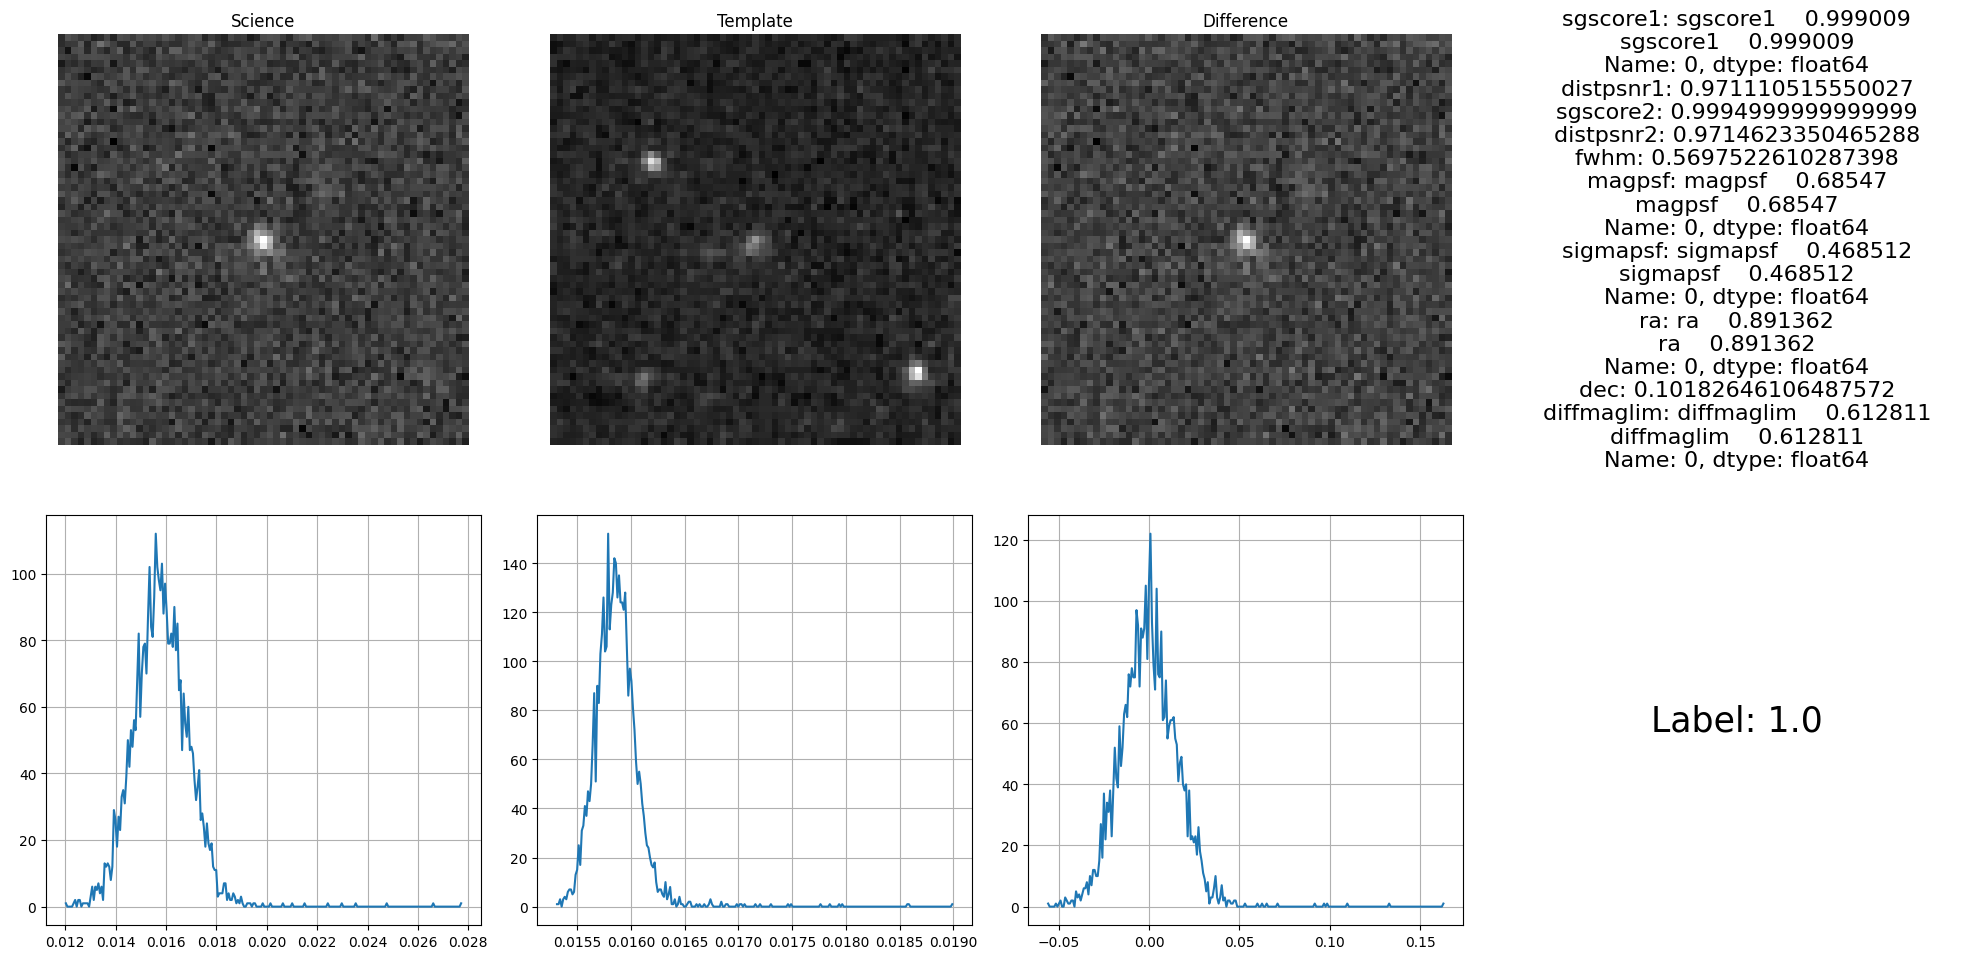

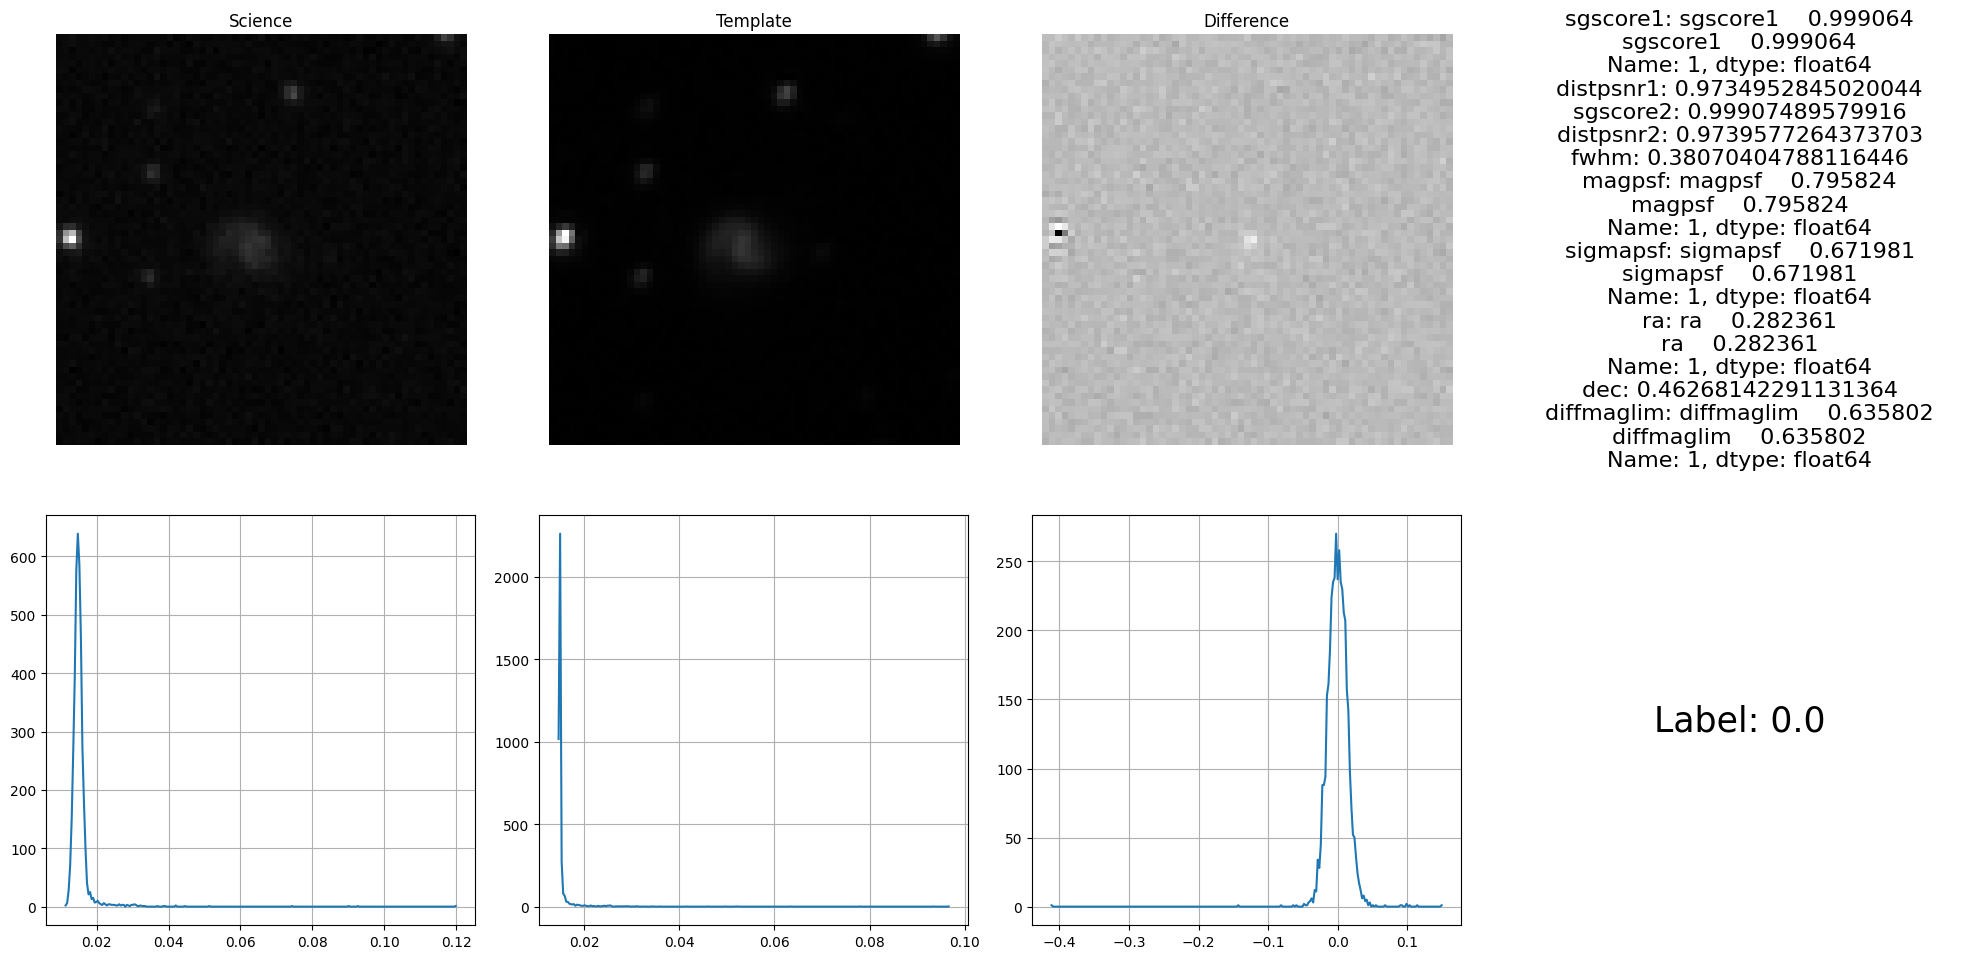

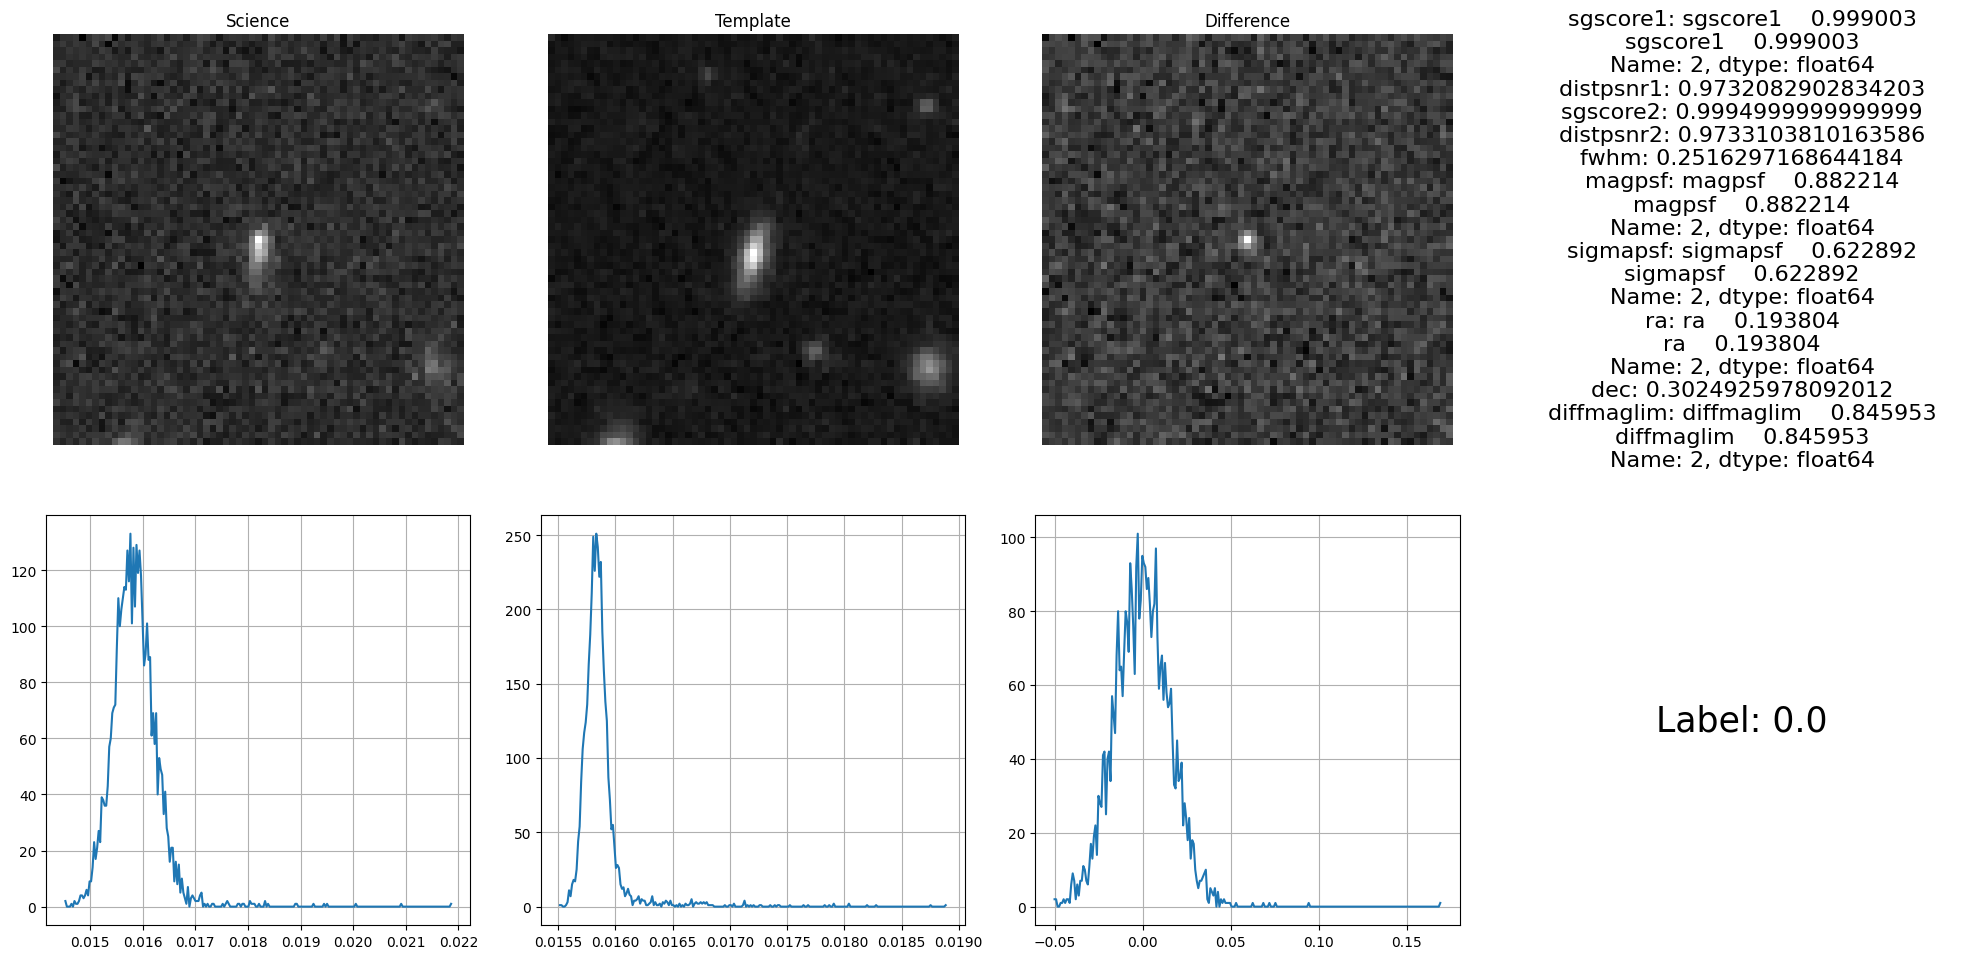

In [71]:
import matplotlib.pyplot as plt

def display_images_with_details(x_data, df_metadata, num_images=3):
    image_titles = ['Science', 'Template', 'Difference']
    
    for i in range(num_images):
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        for j in range(3):
            image = x_data[i, :, :, j]
            axs[0, j].imshow(image, cmap='gray')
            axs[0, j].set_title(image_titles[j])
            axs[0, j].axis('off')

            histogram, bin_edges = np.histogram(image, bins=256, range=(np.min(image), np.max(image)))
            axs[1, j].plot(bin_edges[0:-1], histogram)
            axs[1, j].grid(True)

        metadata_str = "\n".join(f"{col}: {df_metadata.iloc[i][col]}" for col in df_metadata.columns[:10])
        axs[0, 3].text(0.5, 0.5, metadata_str, verticalalignment='center', horizontalalignment='center', fontsize=16)
        axs[0, 3].axis('off')

        range_values_str = f"Label: {df_metadata.iloc[i]['label']}"
        axs[1, 3].text(0.5, 0.5, range_values_str, verticalalignment='center', horizontalalignment='center', fontsize=25)
        axs[1, 3].axis('off')

        plt.tight_layout()
        plt.show()
        
display_images_with_details(x_train, train_df, 3)

# Consistent Value Ranges Across Images
Observing the images, we notice that the value ranges differ, with [0,1] for Science and Template images and [-1,1] for Difference images. The goal is to standardize the value ranges of all images to be between 0 and 1.

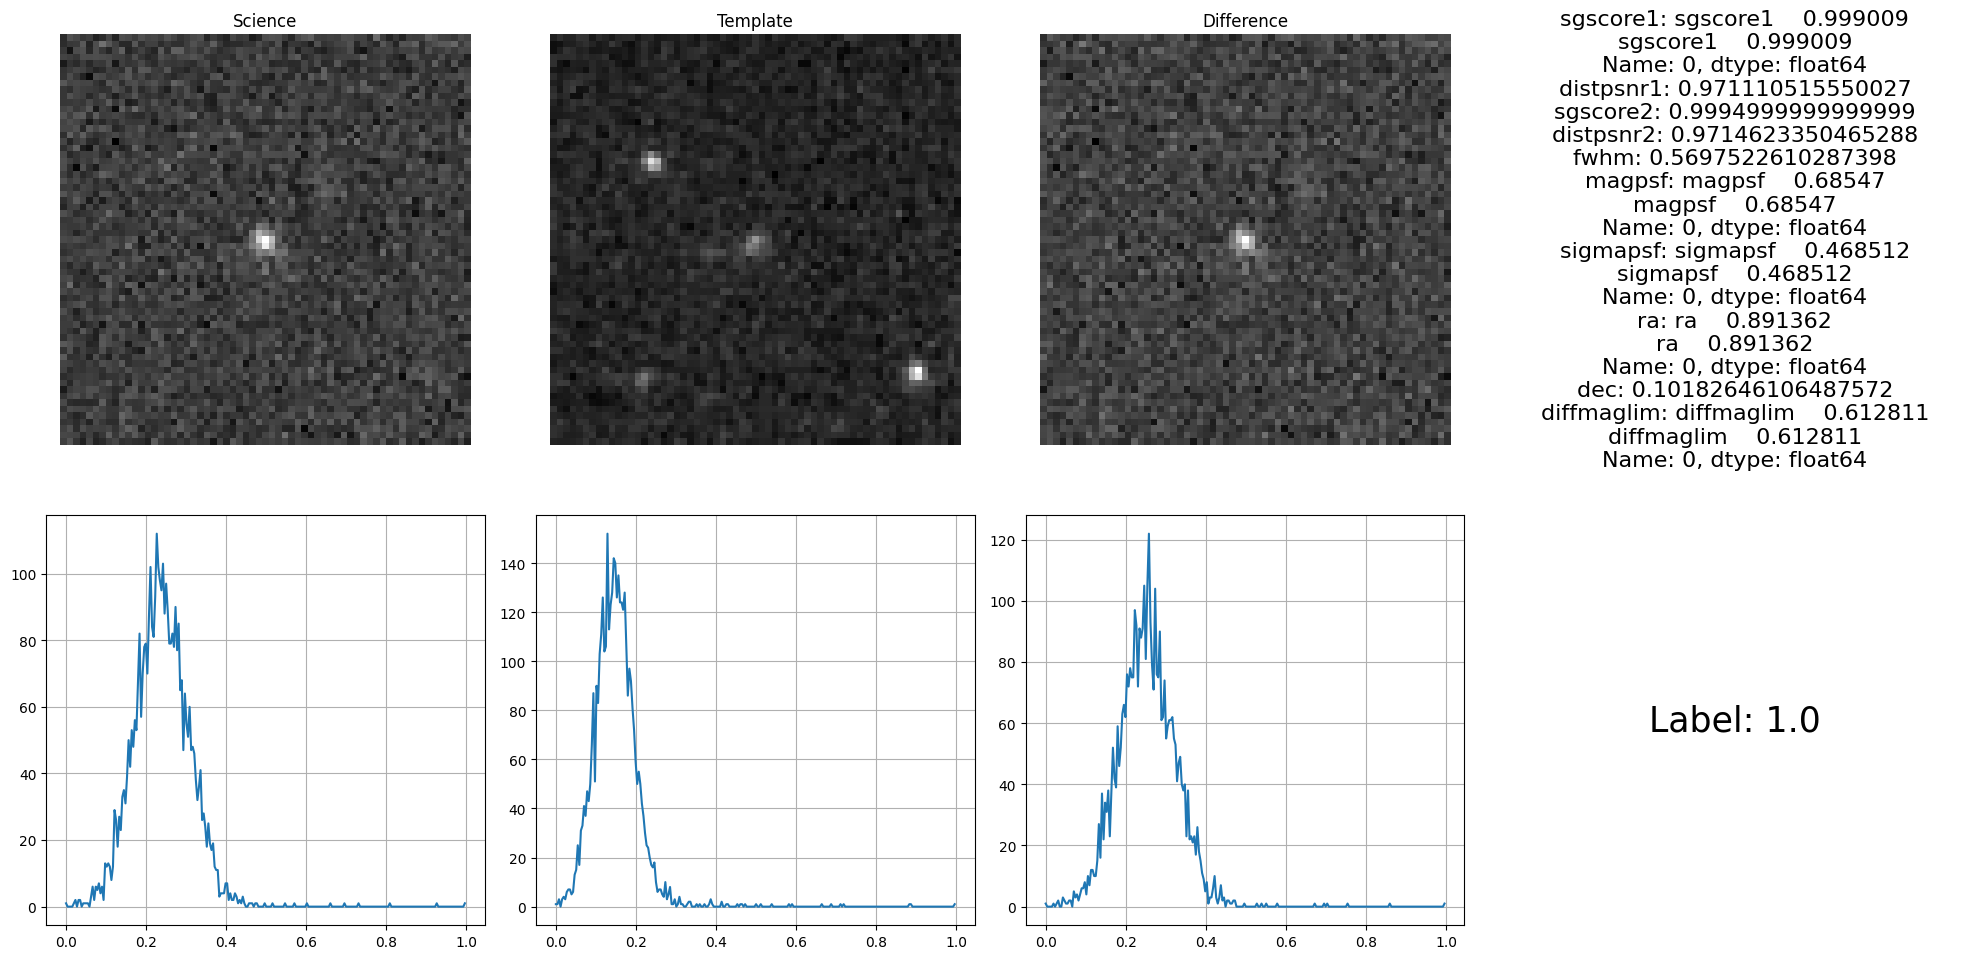

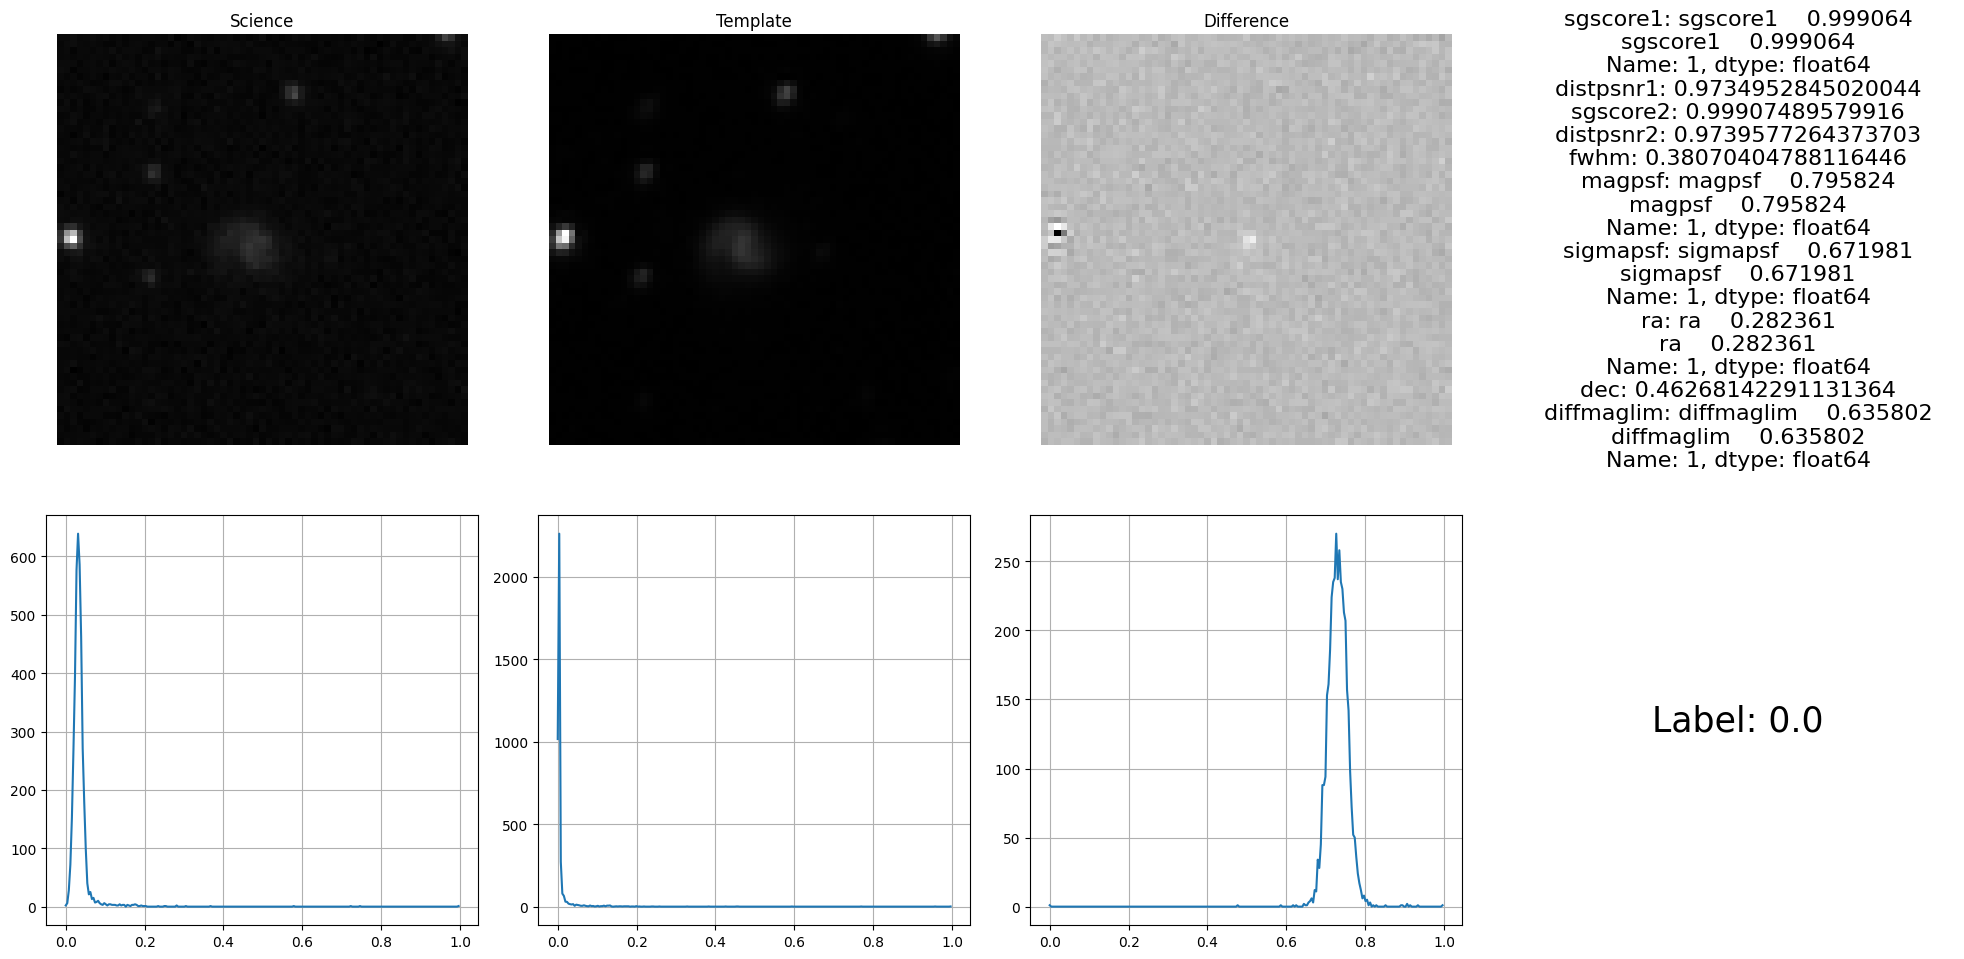

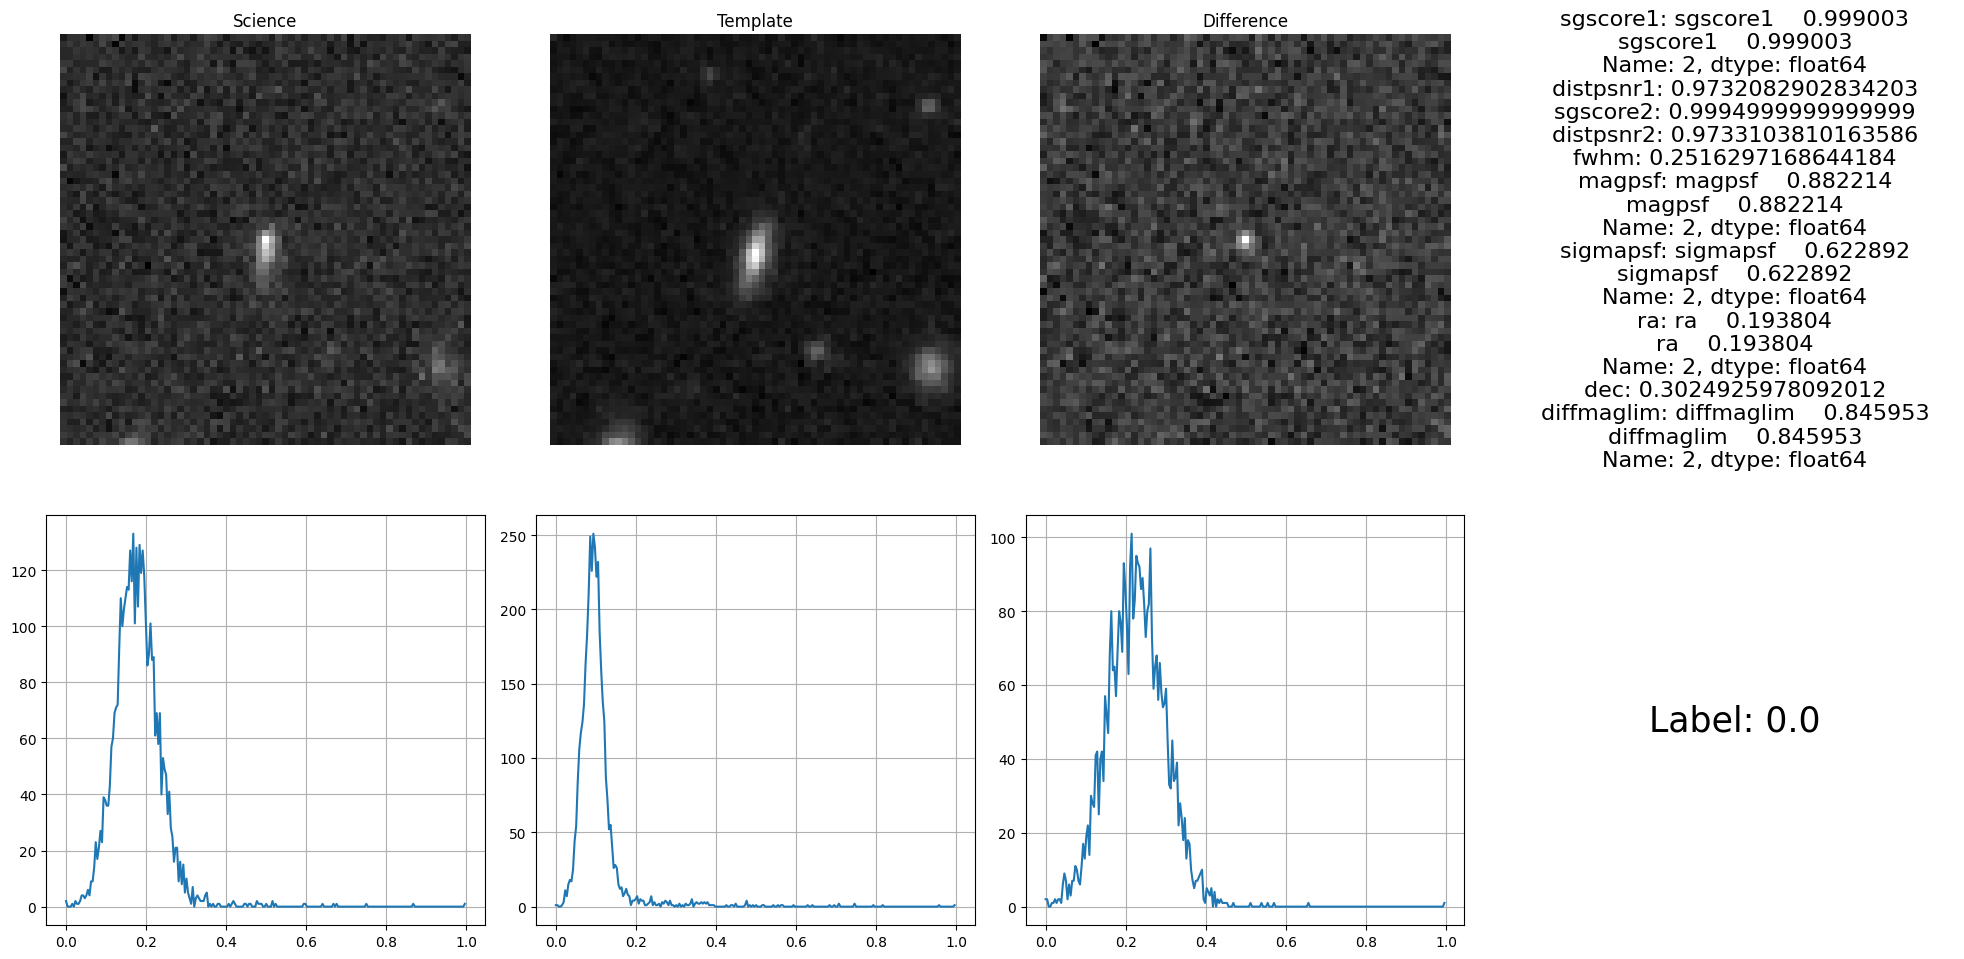

In [72]:
def normalize_and_rescale_images(x_data, new_min=0, new_max=1):
    normalized_rescaled_data = np.empty_like(x_data)
    
    for i in range(x_data.shape[0]):
        for j in range(x_data.shape[3]):
            # Normalize the image to [0, 1]
            normalized_image = (x_data[i, :, :, j] - np.min(x_data[i, :, :, j])) / (np.max(x_data[i, :, :, j]) - np.min(x_data[i, :, :, j]))
            # Rescale the image to [new_min, new_max]
            rescaled_image = new_min + (normalized_image * (new_max - new_min))
            normalized_rescaled_data[i, :, :, j] = rescaled_image
    
    return normalized_rescaled_data

x_train = normalize_and_rescale_images(x_train)
x_val = normalize_and_rescale_images(x_val)
x_test = normalize_and_rescale_images(x_test)

display_images_with_details(x_train, train_df, 3)

# Examining Data Distribution (Metadata) Relative to Classes (Label 0 and Label 1)
Next, let's look at the distribution of data (metadata) in relation to the classes (label 0 and label 1).

In [73]:
def plot_label_distribution(df_metadata):
    label_counts = df_metadata['label'].value_counts()
    
    plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])
    
    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(label_counts.index, ['Label 0', 'Label 1'])
    plt.grid(axis='y')
    
    plt.show()

Train Label Distribution


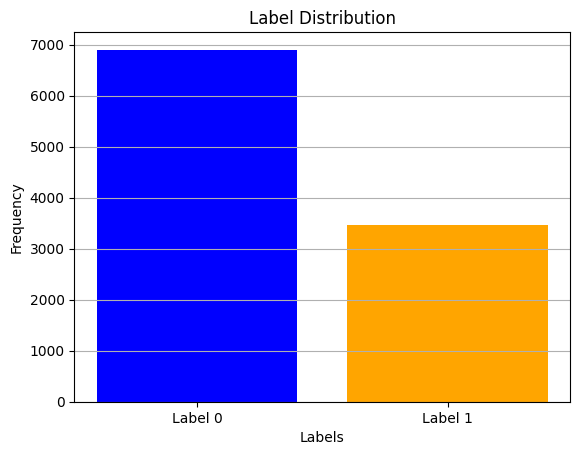

Validation Label Distribution


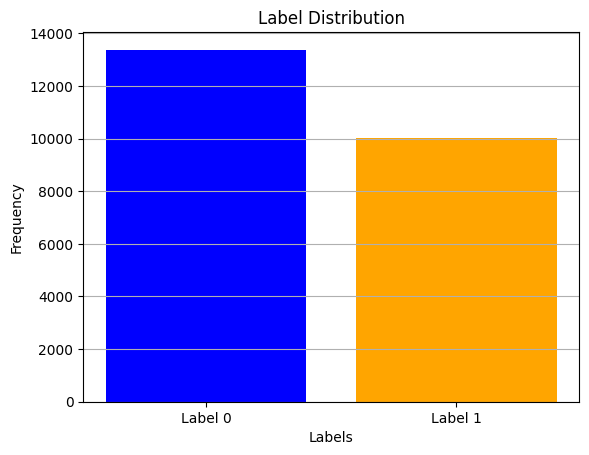

Test Label Distribution


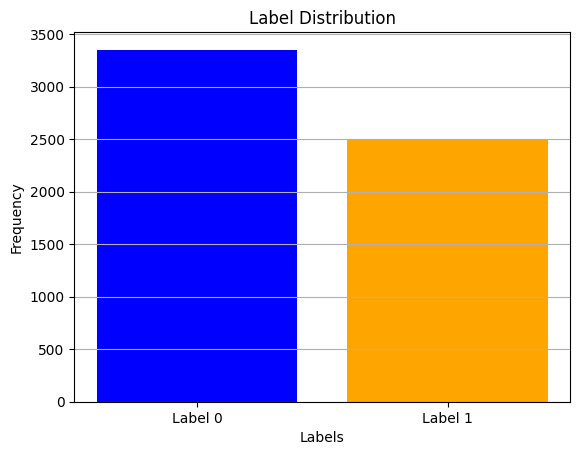

In [74]:
print("Train Label Distribution")
plot_label_distribution(train_df)

print("Validation Label Distribution")
plot_label_distribution(val_df) 

print("Test Label Distribution")
plot_label_distribution(test_df) 

# Weighting Labels for Better Model Prediction
To assist the model in making better predictions, we'll add a weight to the labels with fewer data points.

In [39]:
# weight data on number of ALERTS per class
num_training_examples_per_class = np.array([np.sum(train_df['label'] == 0), np.sum(train_df['label'] == 1)])

# fewer examples -> larger weight
weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
normalized_weight = weights / np.max(weights)

class_weight = {i: w for i, w in enumerate(normalized_weight)}
print(f"Class weights: {class_weight}")

Class weights: {0: 0.5017396346767178, 1: 1.0}


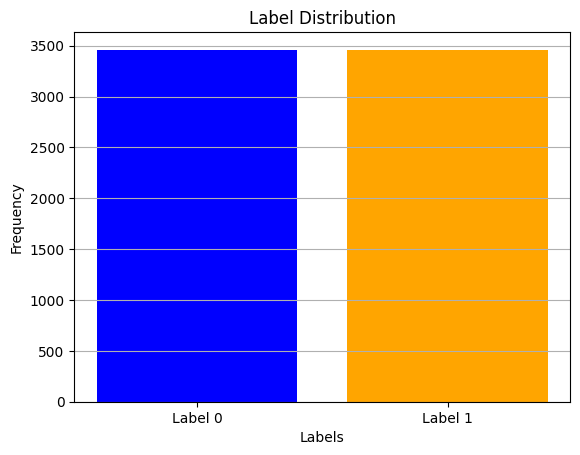

In [75]:
def plot_weighted_label_distribution(df_metadata, class_weight):
    label_counts = df_metadata['label'].value_counts().sort_index()

    weighted_counts = label_counts * label_counts.index.map(class_weight).values

    plt.bar(weighted_counts.index, weighted_counts.values, color=['blue', 'orange'])
    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(weighted_counts.index, ['Label 0', 'Label 1'])
    plt.grid(axis='y')
    plt.show()

plot_weighted_label_distribution(train_df, class_weight)

In [41]:
data_dict = {}

data_dict['train'] = (x_train, y_train, train_df)
data_dict['val'] = (x_val, y_val, val_df)
data_dict['test'] = (x_test, y_test, test_df)

# Model Research and Inspiration
For this model, I first conducted research to see if the subject had been considered before.

I was inspired by the model from this research paper: https://iopscience.iop.org/article/10.3847/1538-3881/abe853/pdf. When testing to increase the number of layers or parameters for the convolutional branch, my model overfitted. Therefore, I decided to stick with two layers of 16 and two layers of 32.

For the metadata branch, I increased the parameters to have one layer of 64 and one of 32.

Replacing Conv2D with SeparableConv2D reduces the parameters and improves computational efficiency while maintaining feature extraction capability. Using GlobalAveragePooling2D instead of Flatten helps reduce overfitting by preserving the essential spatial information of the extracted features.

In [42]:
def BTSModelSep(config):
    # based on the config passed, generate the model
    # first we prepare the input layers
    triplet_input = keras.Input(shape=(63, 63, 3), name='triplet')
    meta_input = keras.Input(shape=(40,), name='metadata')

    # Conv branch
    x = SeparableConv2D(16, (3, 3), activation='relu', padding="same")(triplet_input)
    x = SeparableConv2D(16, (3, 3), activation='relu', padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(config["dropout_1"])(x)

    x = SeparableConv2D(32, (3, 3), activation='relu', padding="same")(x)
    x = SeparableConv2D(32, (3, 3), activation='relu', padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(config["dropout_2"])(x)

    x = GlobalAveragePooling2D()(x)

    # Metadata branch
    y = Dense(64, activation='relu')(meta_input)
    y = Dropout(config["dropout_3"])(y)
    y = Dense(32, activation='relu')(y)

    # Concatenate the two branches
    combined = Concatenate()([x, y])
    x = Dense(32, activation='relu')(combined)
    x = Dropout(config["dropout_3"])(x)
    output = Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[triplet_input, meta_input], outputs=output)

    return model

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint

def train(config, data_dict, model):
    WandBLogger = wandb.keras.WandbMetricsLogger(log_freq=5)
    loss = config['loss']

    # DATA GENERATORS
    print("===> Creating Data Generators...")
    training_generator, validation_generator, t_generator, v_generator = datagenerator(data_dict, config)

    x_train, y_train, train_df = data_dict['train']
    x_val, y_val, val_df = data_dict['val']
    x_test, y_test, test_df = data_dict['test']
    
    print("--OK--")

    # MODEL
    print("===> Creating Model", end=" | ")
    model = model(config)
    print("OK")
    
    # CALLBACKS
    print("===> Creating Callbacks", end=" | ")
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=config["early_stopping_patience"],
    )

    LR_plateau = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        verbose=1,
        patience=config["LR_plateau_patience"],
        factor=config["reduce_LR_factor"],
        min_lr=config["reduce_LR_minLR"]
    )
    
    checkpoint = ModelCheckpoint(
        'best_model_weights.tf',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
    )
    print("OK")

    # OPTIMIZER
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=config['learning_rate'], beta_1=config['beta_1'], beta_2=config['beta_2'])
    
    # TRAINING
    print("===> Training Model...")
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    h = model.fit(
        training_generator,
        steps_per_epoch=0.8*len(x_train) // config["batch_size"],
        validation_data=validation_generator,
        validation_steps=(0.8*len(x_val)) // config["batch_size"],
        epochs=50,
        class_weight=class_weight,
        verbose=1, callbacks=[early_stopping, LR_plateau, WandBLogger, checkpoint]
    )

    print("--OK--")

    # TEST ACCURACY
    print("===> Calculating Test Accuracy", end=" | ")
    imgs_test = x_test
    cols_test = test_df.drop("label", axis=1)
    targets_test = test_df["label"]

    pred = model.predict([x_test, cols_test], batch_size=config['batch_size'], verbose=1)
    round_pred = np.round(pred).astype(int)
    results = round_pred == targets_test.values.reshape(-1,1)

    print(f"Test accuracy: {100*np.sum(results) / len(results):.2f}%")
    print("OK")
    
    # SEND TO W&B
    print("===> Sending Results to W&B", end=" | ")
    wandb.log({"test_accuracy": 100*np.sum(results) / len(results)})
    print("OK")
    
    plot_history(h)
    plot_metric(targets_test, round_pred, pred)

In [ ]:
def sweep_train(config=None):
    with wandb.init(config=config) as run:
        train(run.config, data_dict, BTSModelSep)

In [ ]:
sweep_id = "vk0lhxq1" #replace with your sweep id here
wandb.agent(sweep_id=sweep_id, function=sweep_train, count=20, project="BTSbot")

# Hyperparameter Research with WandB
After searching for hyperparameters using the WandB site, here are the parameters I am using.

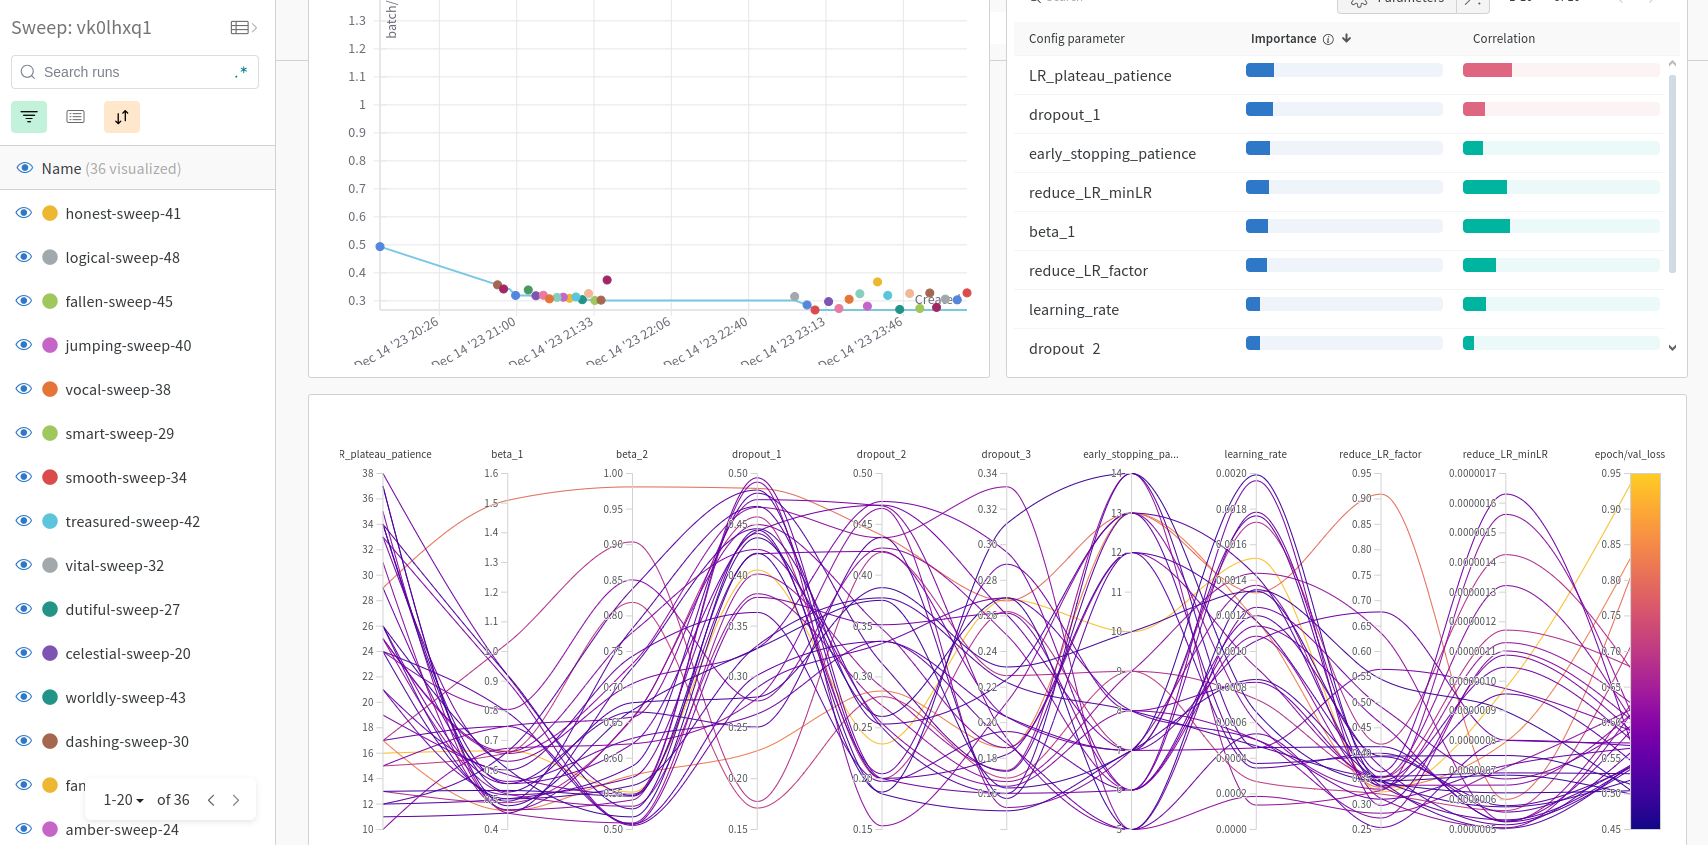

In [62]:
config = {
    'batch_size': 64,
    'learning_rate': 0.0005,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'random_seed': 42,
    'train_data_version': "ZTFSS",
    'early_stopping_patience': 8,
    'LR_plateau_patience': 8,
    'reduce_LR_factor': 0.3,
    'reduce_LR_minLR': 0.0000001, 
    'beta_1': 0.5,
    'beta_2': 0.5,
    'dropout_1': 0.5,
    'dropout_2': 0.3,
    'dropout_3': 0.3,
    'dropout_4': 0.2,
}
config

{'batch_size': 64,
 'learning_rate': 0.0005,
 'loss': 'binary_crossentropy',
 'optimizer': 'adam',
 'random_seed': 42,
 'train_data_version': 'ZTFSS',
 'early_stopping_patience': 8,
 'LR_plateau_patience': 8,
 'reduce_LR_factor': 0.3,
 'reduce_LR_minLR': 1e-07,
 'beta_1': 0.5,
 'beta_2': 0.5,
 'dropout_1': 0.5,
 'dropout_2': 0.3,
 'dropout_3': 0.3,
 'dropout_4': 0.2}

===> Creating Data Generators...
--OK--
===> Creating Model | OK
===> Creating Callbacks | OK
===> Training Model...
Epoch 1/50


2023-12-17 14:20:57.651998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_41/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


129/129 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.6126
Epoch 1: val_loss improved from inf to 0.61189, saving model to best_model_weights.tf
129/129 [==============================] - 17s 99ms/step - loss: 0.4444 - accuracy: 0.6126 - val_loss: 0.6119 - val_accuracy: 0.7101 - lr: 5.0000e-04
Epoch 2/50
129/129 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.7238
Epoch 2: val_loss improved from 0.61189 to 0.57338, saving model to best_model_weights.tf
129/129 [==============================] - 12s 97ms/step - loss: 0.3911 - accuracy: 0.7238 - val_loss: 0.5734 - val_accuracy: 0.7050 - lr: 5.0000e-04
Epoch 3/50
129/129 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.7537
Epoch 3: val_loss improved from 0.57338 to 0.55493, saving model to best_model_weights.tf
129/129 [==============================] - 13s 100ms/step - loss: 0.3586 - accuracy: 0.7537 - val_loss: 0.5549 - val_accuracy: 0.7151 - lr: 5.0000e-04
Epoch 

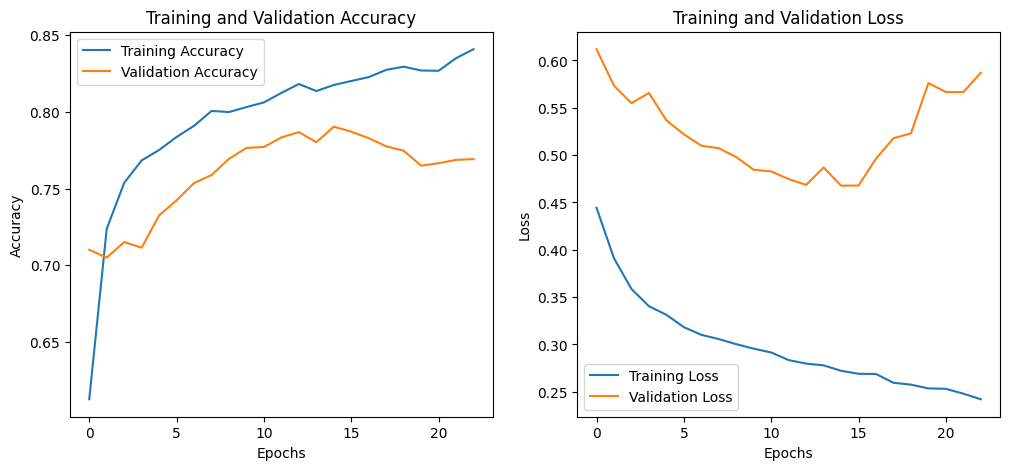

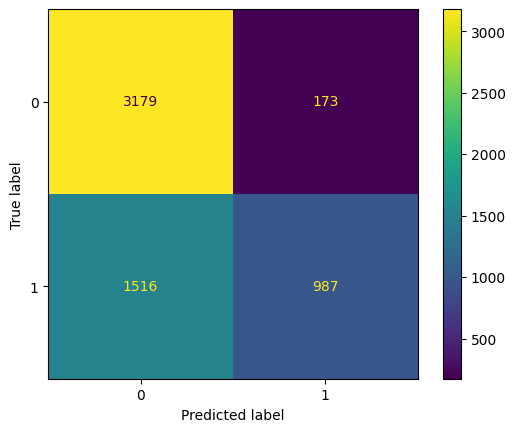

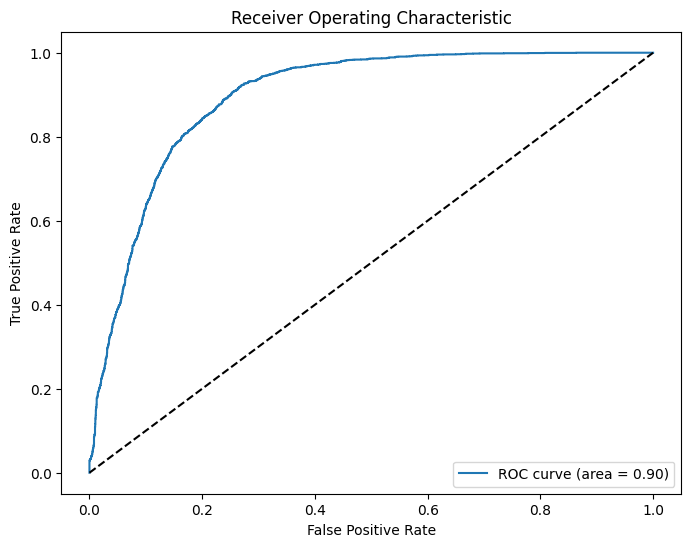

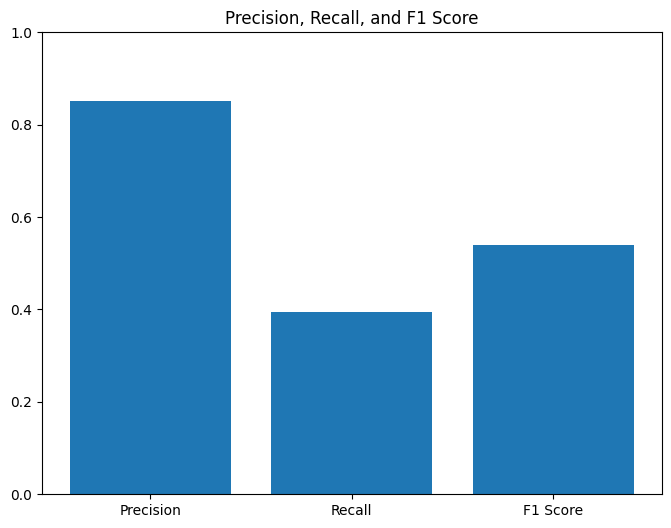

Precision: 0.8508620689655172
Recall: 0.39432680783060325
F1 Score: 0.5389025389025389
AUC: 0.8953140479634463


In [63]:
train(config, data_dict, BTSModelSep)

92/92 [==============================] - 0s 3ms/step
Test accuracy: 74.81%
OK


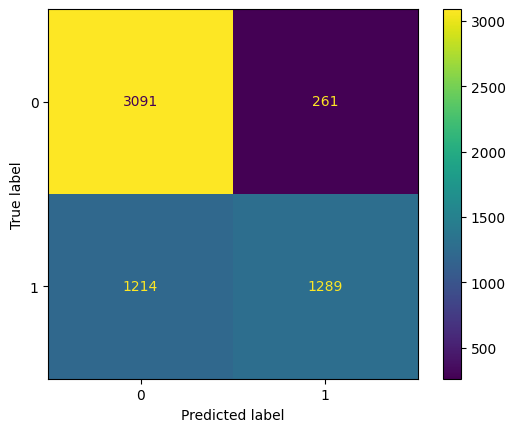

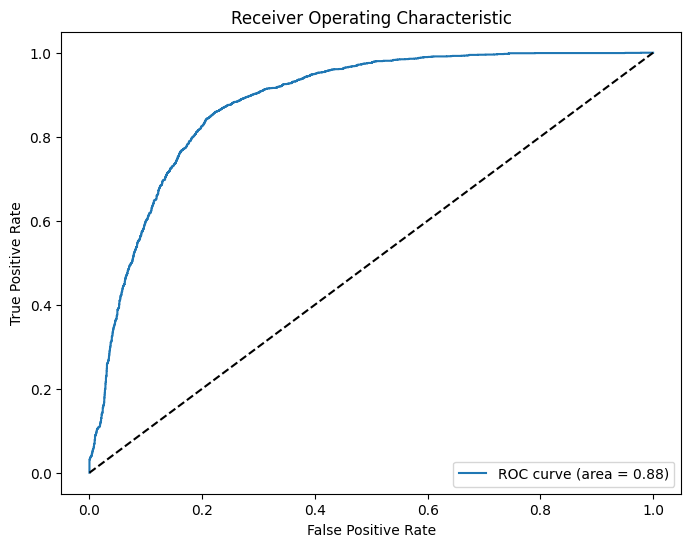

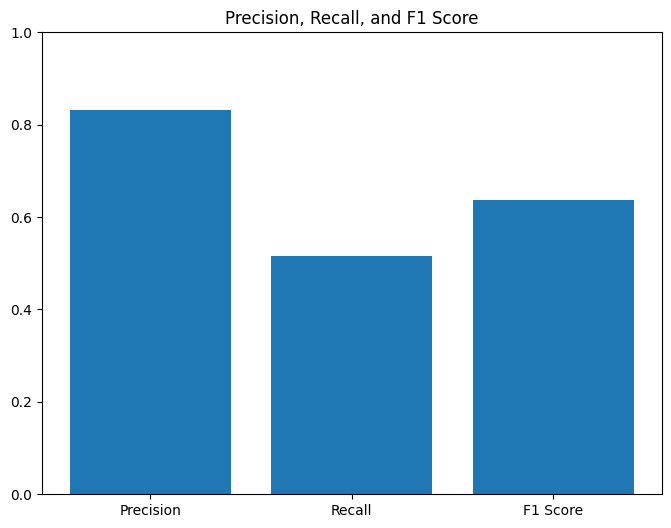

Precision: 0.8316129032258065
Recall: 0.5149820215741111
F1 Score: 0.6360720453984703
AUC: 0.8811931648608782


In [64]:
model = BTSModelSep(config)
model.load_weights('best_model_weights.tf')

imgs_test = x_test
cols_test = test_df.drop("label", axis=1)
targets_test = test_df["label"]

pred = model.predict([x_test, cols_test], batch_size=config['batch_size'], verbose=1)
round_pred = np.round(pred).astype(int)
results = round_pred == targets_test.values.reshape(-1,1)

print(f"Test accuracy: {100*np.sum(results) / len(results):.2f}%")
print("OK")
    
plot_metric(targets_test, round_pred, pred)

The model exhibits a robust precision at 83.16%, indicating a high accuracy in its positive predictions. However, its recall of 51.50% reveals a challenge in identifying all the positive instances.

The F1 score, at 63.61%, reflects this imbalance between precision and recall, suggesting that the model, while reliable in its positive predictions, isn't as effective in capturing all positive cases. This points towards a need for refinement in the model's ability to recognize positive instances.

The AUC of the model is 88.12%, which underscores its strong capability in differentiating between the classes effectively.

In conclusion, the model is efficient and reliable in its predictive accuracy, particularly in terms of precision and class differentiation. However, the relatively lower recall and F1 score highlight areas for improvement, specifically in enhancing the model's sensitivity to positive cases.

# Exploring a ResNet-Inspired Model Architecture

In [57]:
from tensorflow.keras.layers import BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Input, Concatenate, Dropout

def resnet_block(x, filters, kernel_size, config):
    y = Conv2D(filters, kernel_size, padding='same')(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Dropout(config["dropout_1"])(y)

    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    out = Add()([x, y])
    out = ReLU()(out)
    return out

def BTS_ResNet(config):
    triplet_input = keras.Input(shape=(63, 63, 3), name='triplet')
    meta_input = keras.Input(shape=(40,), name='metadata')

    # Conv branch
    x = Conv2D(16, (3, 3), padding='same')(triplet_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = resnet_block(x, 16, (3, 3), config)
    x = Conv2D(32, (3, 3), padding='same')(triplet_input)
    x = Dropout(config["dropout_2"])(x)
    x = resnet_block(x, 32, (3, 3), config)
    x = GlobalAveragePooling2D()(x)

    # Metadata input branch
    y = Dense(64, activation='relu')(meta_input)
    y = Dropout(config["dropout_3"])(y)
    y = Dense(32, activation='relu')(y)

    # Concatenate
    concatenated = Concatenate()([x, y])
    concatenated = Dense(32, activation='relu')(concatenated)
    concatenated = Dropout(config["dropout_4"])(concatenated)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(concatenated)
    model = keras.Model(inputs=[triplet_input, meta_input], outputs=outputs)
    
    return model

===> Creating Data Generators...
--OK--
===> Creating Model | OK
===> Creating Callbacks | OK
===> Training Model...
Epoch 1/50


2023-12-17 14:10:01.506767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


129/129 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.6887
Epoch 1: val_loss improved from inf to 0.66930, saving model to best_model_weights.tf
129/129 [==============================] - 16s 98ms/step - loss: 0.4051 - accuracy: 0.6887 - val_loss: 0.6693 - val_accuracy: 0.5752 - lr: 5.0000e-04
Epoch 2/50
129/129 [==============================] - ETA: 0s - loss: 0.3817 - accuracy: 0.7211
Epoch 2: val_loss improved from 0.66930 to 0.66227, saving model to best_model_weights.tf
129/129 [==============================] - 13s 100ms/step - loss: 0.3817 - accuracy: 0.7211 - val_loss: 0.6623 - val_accuracy: 0.6054 - lr: 5.0000e-04
Epoch 3/50
129/129 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.7460
Epoch 3: val_loss improved from 0.66227 to 0.59584, saving model to best_model_weights.tf
129/129 [==============================] - 13s 98ms/step - loss: 0.3562 - accuracy: 0.7460 - val_loss: 0.5958 - val_accuracy: 0.6700 - lr: 5.0000e-04
Epoch 

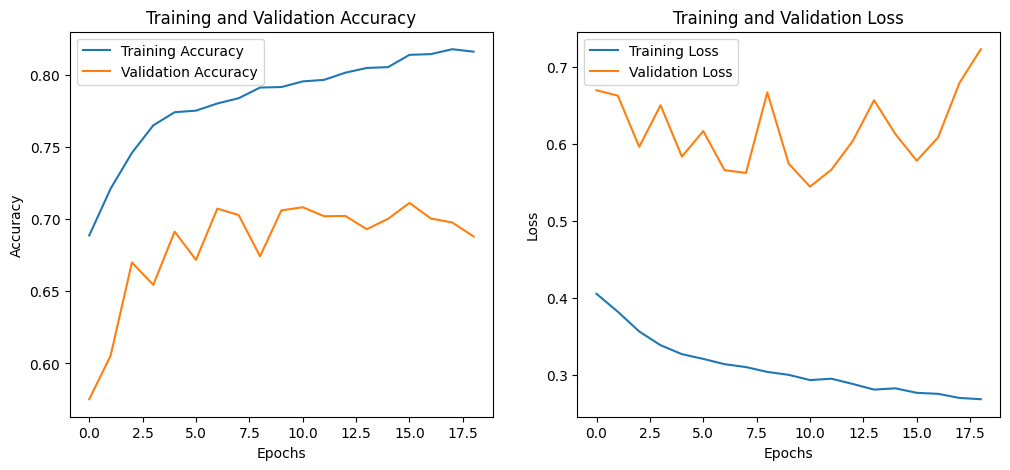

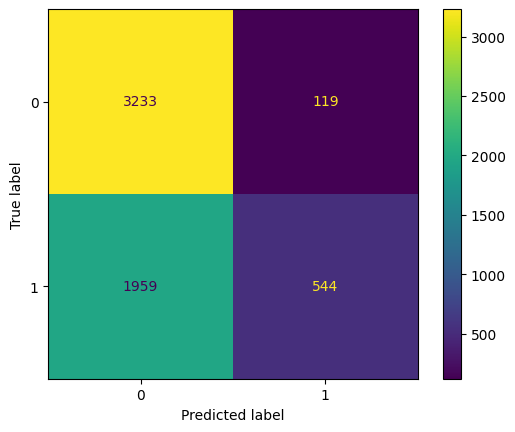

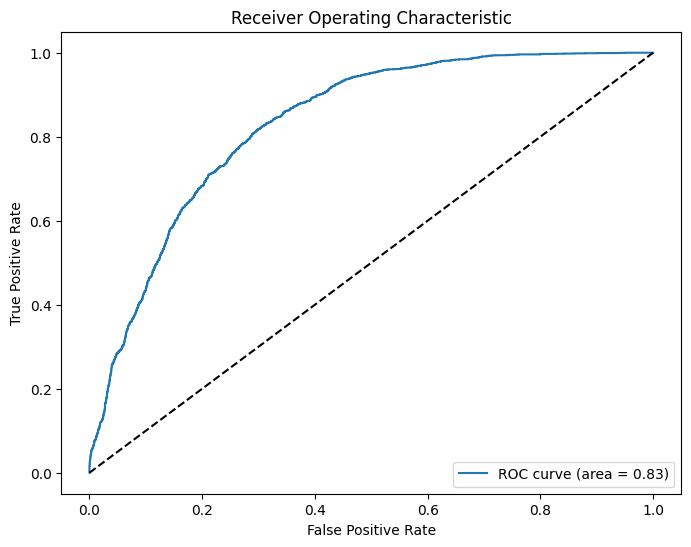

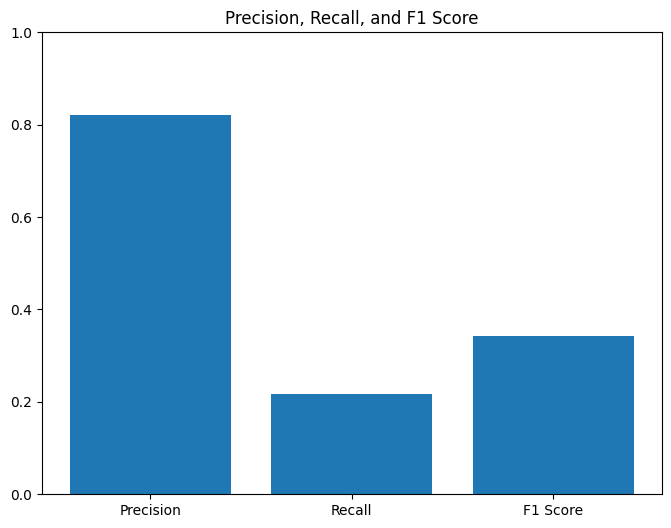

Precision: 0.8205128205128205
Recall: 0.21733919296843787
F1 Score: 0.34365129500947567
AUC: 0.8314433181375667


In [58]:
train(config, data_dict, BTS_ResNet)

# Conclusion

To try and enhance the model's performance, I first aimed to understand the data. I displayed my data, examining columns and images to comprehend the nature of the data, its type (numeric, boolean, etc.), and its range of values (a model tends to learn more effectively with data ranges between 0 and 1). Subsequently, I decided to retain 40 metadata features. I thought that selecting metadata which shows a significant average difference between labels 0 and 1 would help improve the model's performance. To modify the base model, I conducted research and came across a research paper that outlined the model used. After researching SeparableConv and GlobalAveragePooling layers (which I had previously used in a project with the UNET model), I utilized the WandB site for hyperparameter tuning and finally conducted the final training with early stopping. I saved the model weights whenever the validation loss was at its lowest. This allows me to later load the model directly with the best weights from my training sessions. I was unable to significantly improve the model's performance; other techniques, such as using pre-trained models, could be explored. I tested a model similar to the ResNet architecture, but the performance was not as expected.
